# Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# Read in data

In [2]:
athletes = pd.read_csv("athletes.csv")
athletes.head()

athlete_id           name               region          team  \
0      2554.0      Pj Ablang           South West   Double Edge   
1      3517.0  Derek Abdella                  NaN           NaN   
2      4691.0            NaN                  NaN           NaN   
3      5164.0    Abo Brandon  Southern California  LAX CrossFit   
4      5286.0    Bryce Abbey                  NaN           NaN   

              affiliate gender   age  height  weight   fran  ...  snatch  \
0  Double Edge CrossFit   Male  24.0    70.0   166.0    NaN  ...     NaN   
1                   NaN   Male  42.0    70.0   190.0    NaN  ...     NaN   
2                   NaN    NaN   NaN     NaN     NaN    NaN  ...     NaN   
3          LAX CrossFit   Male  40.0    67.0     NaN  211.0  ...   200.0   
4                   NaN   Male  32.0    65.0   149.0  206.0  ...   150.0   

   deadlift  backsq  pullups  \
0     400.0   305.0      NaN   
1       NaN     NaN      NaN   
2       NaN     NaN      NaN   
3     375.0   325.0     25.0   
4       NaN   325.0     50.0   

                                                 eat  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3               I eat 1-3 full cheat meals per week|   
4  I eat quality foods but don't measure the amount|   

                                               train  \
0  I workout mostly at a CrossFit Affiliate|I hav...   
1  I have a coach who determines my programming|I...   
2                                                NaN   
3  I workout mostly at a CrossFit Affiliate|I hav...   
4  I workout mostly at a CrossFit Affiliate|I inc...   

                                          background  \
0  I played youth or high school level sports|I r...   
1        I played youth or high school level sports|   
2                                                NaN   
3        I played youth or high school level sports|   
4                           I played college sports|   

                                          experience  \
0  I began CrossFit with a coach (e.g. at an affi...   
1  I began CrossFit with a coach (e.g. at an affi...   
2                                                NaN   
3  I began CrossFit by trying it alone (without a...   
4  I began CrossFit by trying it alone (without a...   

                                            schedule     howlong  
0         I do multiple workouts in a day 2x a week|   4+ years|  
1         I do multiple workouts in a day 2x a week|   4+ years|  
2                                                NaN         NaN  
3                 I usually only do 1 workout a day|   4+ years|  
4  I usually only do 1 workout a day|I strictly s...  1-2 years|  

[5 rows x 27 columns]

In [3]:
# Get the relevant columns only
athletes_clean = athletes.loc[:, ["gender", "age", "height", "weight", "run5k", "deadlift", "eat", "train", "background", "experience", "schedule", "howlong"]].copy()
athletes_clean['age_squared'] = athletes_clean['age']**2
athletes_clean['bmi'] = 703*athletes_clean['weight']/(athletes_clean['height']**2)

# EDA and Cleaning

In [4]:
athletes_clean.describe()

age        height         weight         run5k      deadlift  \
count  331110.000000  1.598690e+05  229890.000000  3.609700e+04  1.153230e+05   
mean       32.516750  1.206217e+02     170.896137  3.411464e+03  6.970503e+02   
std         7.730671  2.097995e+04      58.379799  1.251980e+05  5.523235e+04   
min        13.000000  0.000000e+00       1.000000  1.000000e+00 -5.000000e+02   
25%        27.000000  6.600000e+01     145.000000  1.242000e+03  2.550000e+02   
50%        31.000000  6.900000e+01     170.000000  1.380000e+03  3.450000e+02   
75%        37.000000  7.200000e+01     192.000000  1.560000e+03  4.150000e+02   
max       125.000000  8.388607e+06   20175.000000  8.388607e+06  8.388607e+06   

         age_squared           bmi  
count  331110.000000  1.444280e+05  
mean     1117.102108           inf  
std       542.521473           NaN  
min       169.000000  1.868174e-09  
25%       729.000000  2.343333e+01  
50%       961.000000  2.539408e+01  
75%      1369.000000  2.751795e+01  
max     15625.000000           inf

Definitely some outliers in here. We will have to figure out what to do with those.

In [5]:
athletes_clean.isna().sum()

gender          91896
age             91896
height         263137
weight         193116
run5k          386909
deadlift       307683
eat            329074
train          317175
background     324061
experience     318070
schedule       325131
howlong        313800
age_squared     91896
bmi            278578
dtype: int64

PLENTY of missing values here. Our dataset will be considerably smaller by the time we actually go to model. 

c:\Users\brown\miniconda3\envs\DSenv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


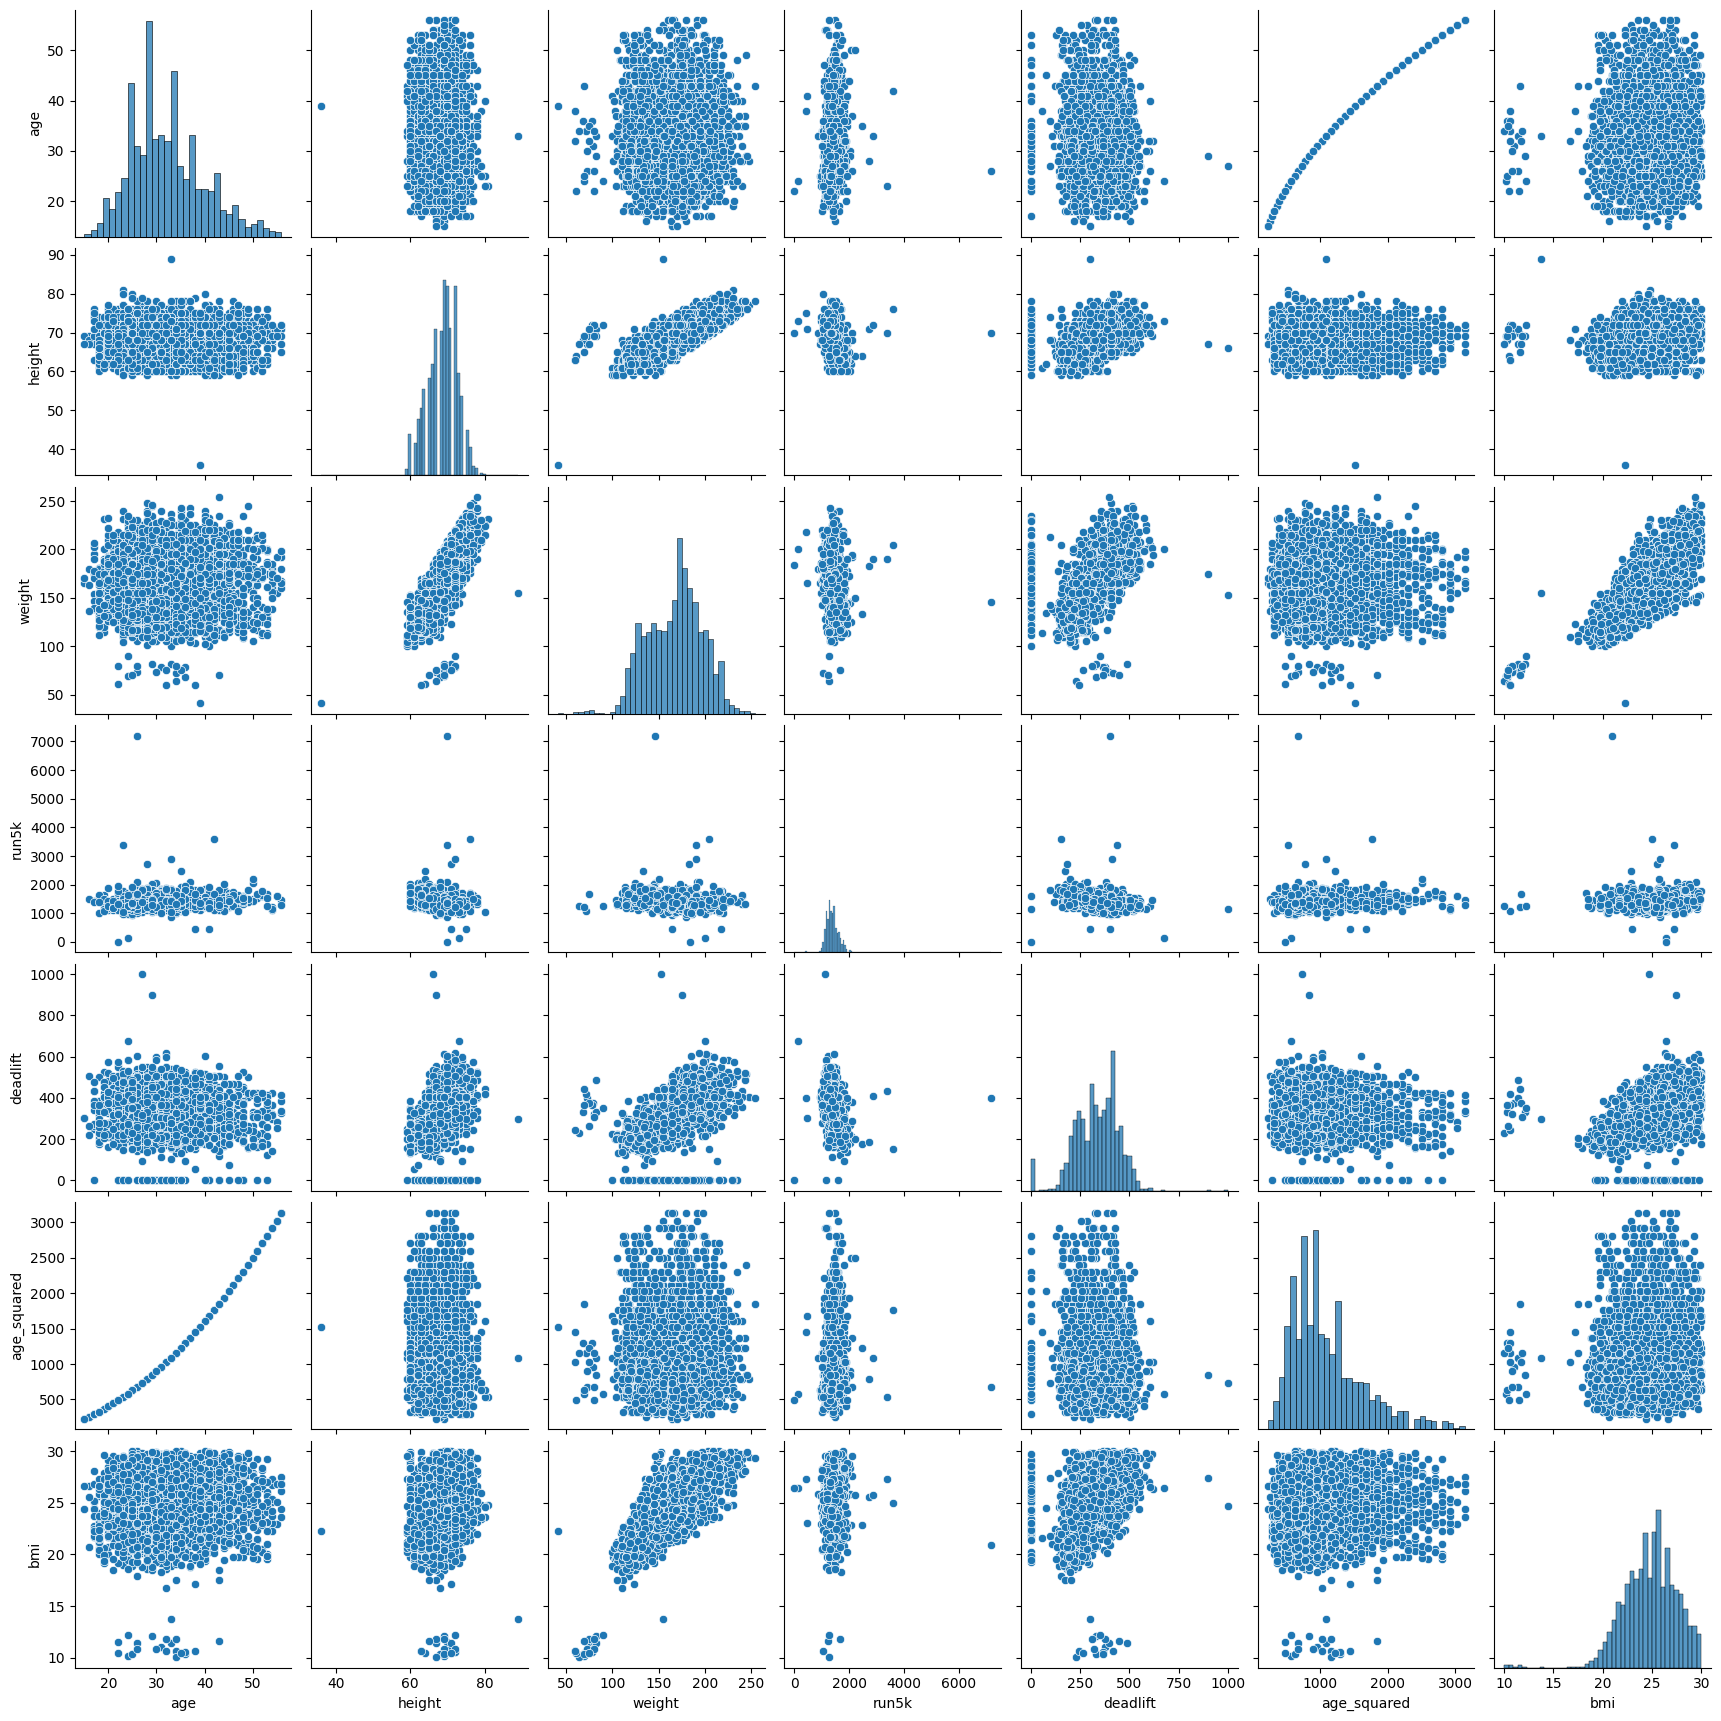

In [6]:
# First sample to make to pairplots able to run
athletes_sampled = athletes_clean.query('bmi <= 30 and bmi >= 10').sample(n = 3500, random_state = 31958)
sns.pairplot(athletes_sampled);

Despite some outliers and some weird looking gaps in age, much of the data looks pretty normally distributed and solid overall. 

In [7]:
# Start by removing weird values from the above plot. 
athletes_clean = athletes_clean.query('weight >= 100 and weight <= 320 and \
                                      height >= 54 and height <= 85 and \
                                      age <= 85 and \
                                      run5k >= 755 and run5k <= 2700 and \
                                      deadlift >= 45 and deadlift <= 1185')

c:\Users\brown\miniconda3\envs\DSenv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


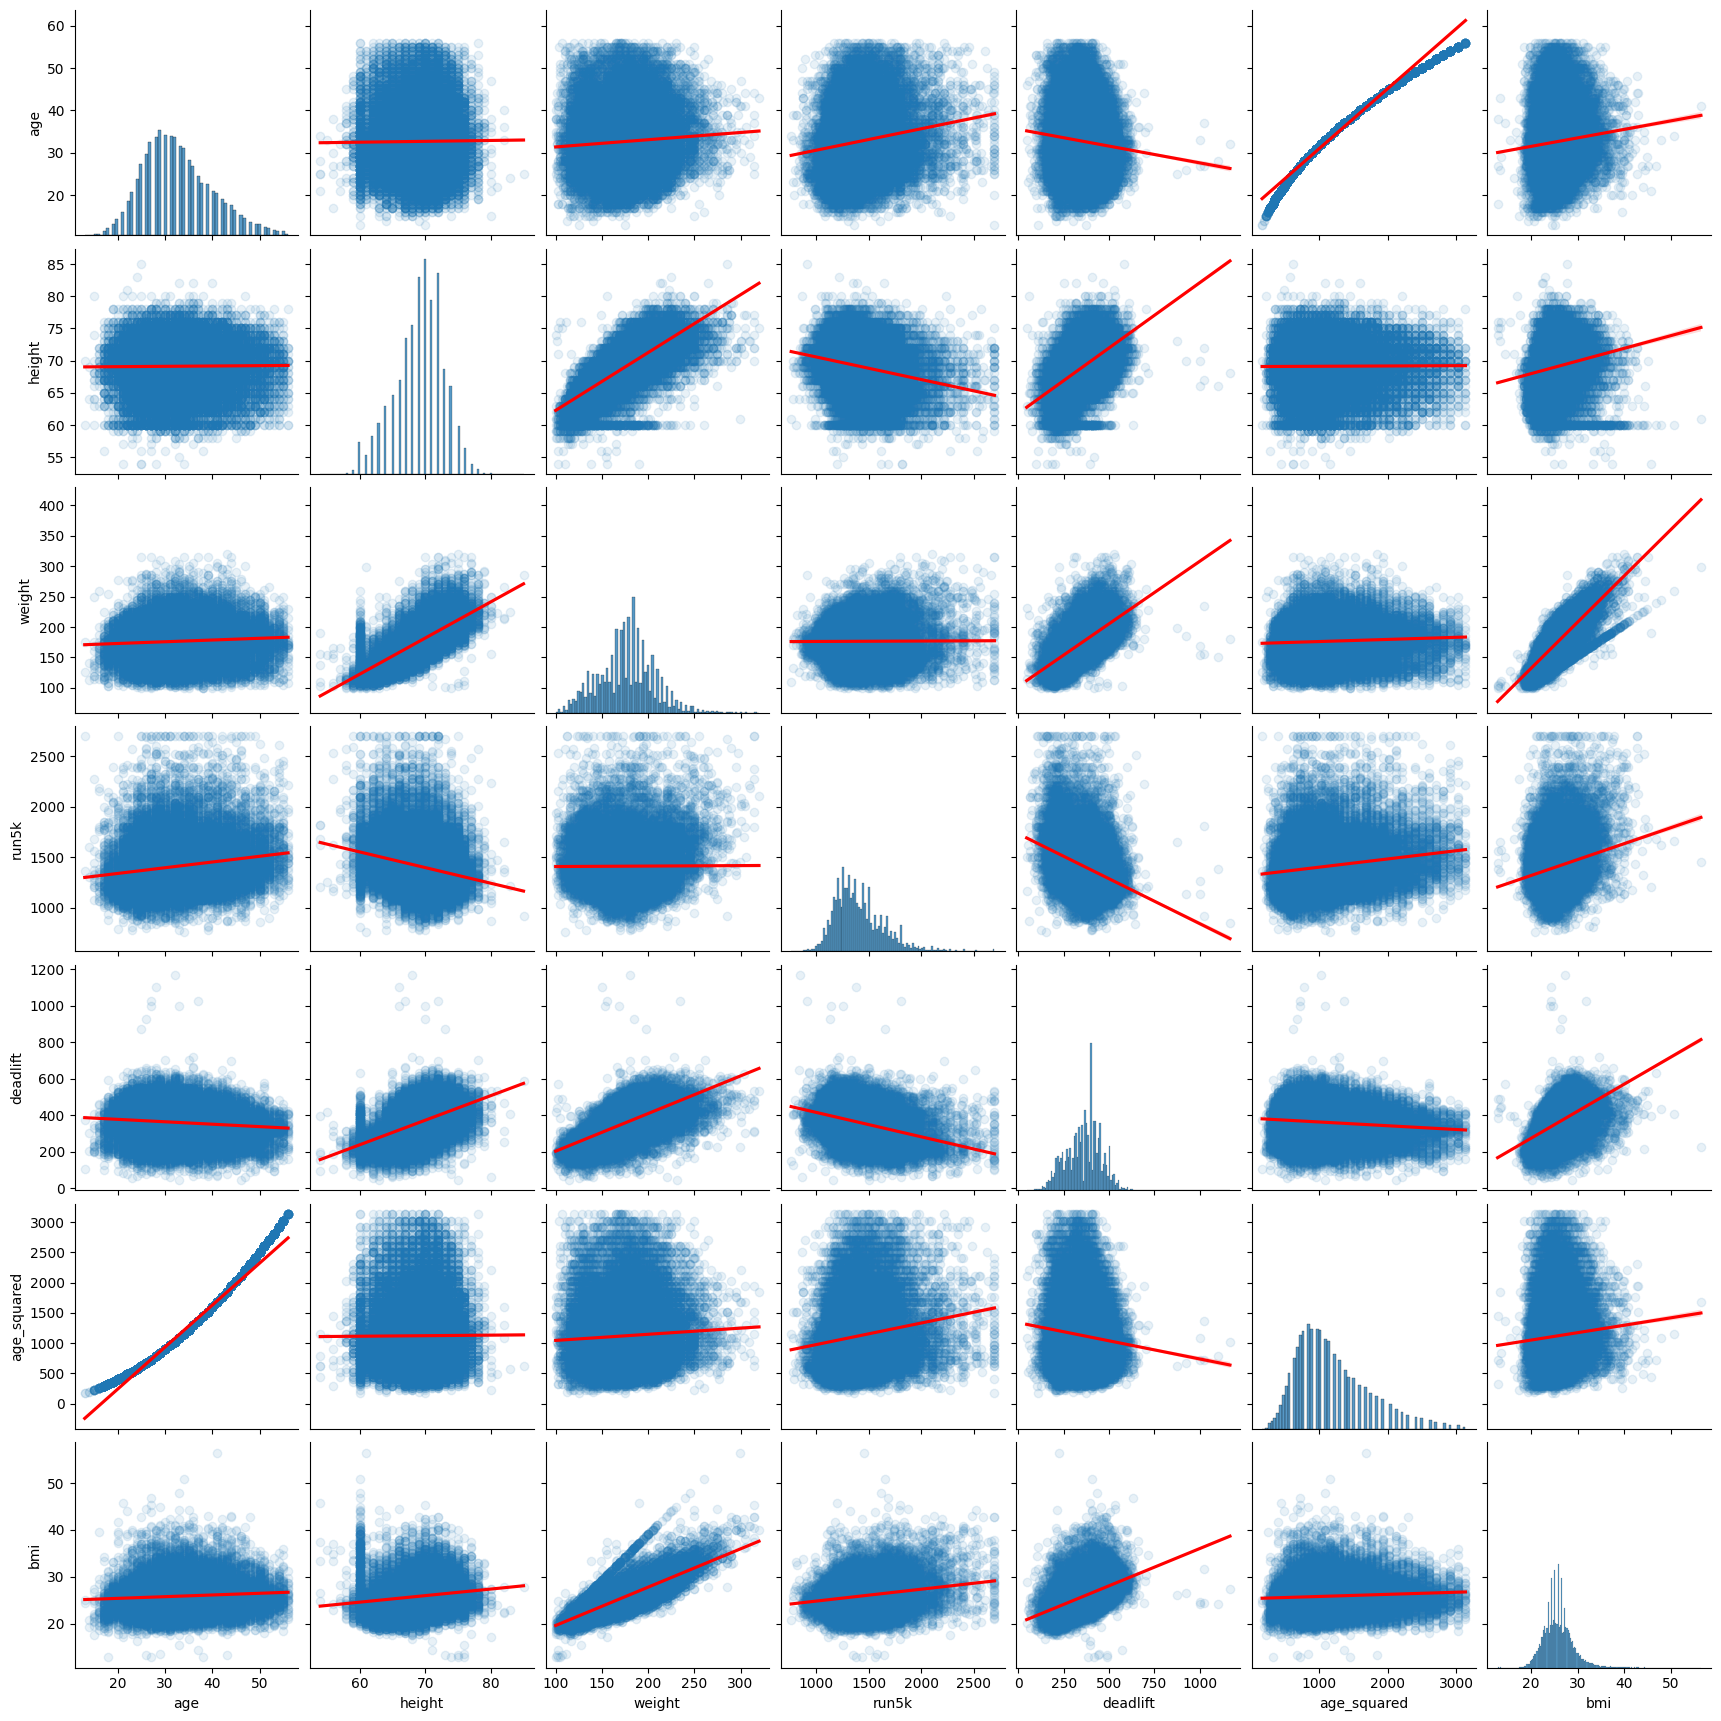

In [8]:
sns.pairplot(athletes_clean, kind = 'reg', plot_kws = {'line_kws': {'color': 'red'}, 'scatter_kws': {'alpha': 0.1}});

Some relationships look considerably less significant now(particularly with 5k time), but let's continue on to the non-numeric data. 
<br>
<br>
Much of the categorical data has multiple answer selected per athlete, so we will need to find a way around this. 

In [9]:
athletes_clean.head()

gender   age  height  weight   run5k  deadlift  \
9    Male  40.0    68.0   177.0  1361.0     365.0   
12   Male  31.0    65.0   150.0  1211.0     465.0   
18   Male  30.0    70.0   155.0  1140.0     335.0   
20   Male  42.0    72.0   210.0  1412.0     515.0   
21   Male  30.0    71.0   200.0  1584.0     385.0   

                                                  eat  \
9   I eat quality foods but don't measure the amount|   
12  I eat quality foods but don't measure the amou...   
18                                                NaN   
20  I eat quality foods but don't measure the amount|   
21                      I eat whatever is convenient|   

                                                train  \
9   I workout mostly at a CrossFit Affiliate|I rec...   
12  I workout mostly at a CrossFit Affiliate|I wri...   
18                                                NaN   
20  I workout mostly at a CrossFit Affiliate|I wri...   
21  I workout mostly at a CrossFit Affiliate|I inc...   

                                           background  \
9   I played youth or high school level sports|I p...   
12  I played youth or high school level sports|I p...   
18                                                NaN   
20        I played youth or high school level sports|   
21  I played youth or high school level sports|I p...   

                                           experience  \
9   I began CrossFit by trying it alone (without a...   
12  I began CrossFit by trying it alone (without a...   
18                                                NaN   
20  I began CrossFit with a coach (e.g. at an affi...   
21  I began CrossFit by trying it alone (without a...   

                                             schedule     howlong  \
9   I usually only do 1 workout a day|I typically ...  2-4 years|   
12   I do multiple workouts in a day 3+ times a week|  2-4 years|   
18                                                NaN         NaN   
20                                                NaN   4+ years|   
21  I do multiple workouts in a day 1x a week|I ty...  1-2 years|   

    age_squared        bmi  
9        1600.0  26.909818  
12        961.0  24.958580  
18        900.0  22.237755  
20       1764.0  28.478009  
21        900.0  27.891291

##### Gender

In [10]:
dummy_gender = pd.get_dummies(athletes_clean['gender']).drop('--', axis = 1)
athletes_clean = pd.concat([athletes_clean, dummy_gender], axis = 1)

##### Eating habits

In [11]:
# Drop rows with NaN in 'eat' column
athletes_clean = athletes_clean.dropna(subset = ['eat'])

# Split the values in the 'eat' column by "|" and create dummy variables
dummy_eats = pd.get_dummies(athletes_clean['eat'].str.split('|', expand = True).stack(), prefix = 'eat').groupby(level = 0).sum()

# Drop the column corresponding to the empty answer ('')
dummy_eats = dummy_eats.drop(columns = 'eat_')

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_eats], axis=1)

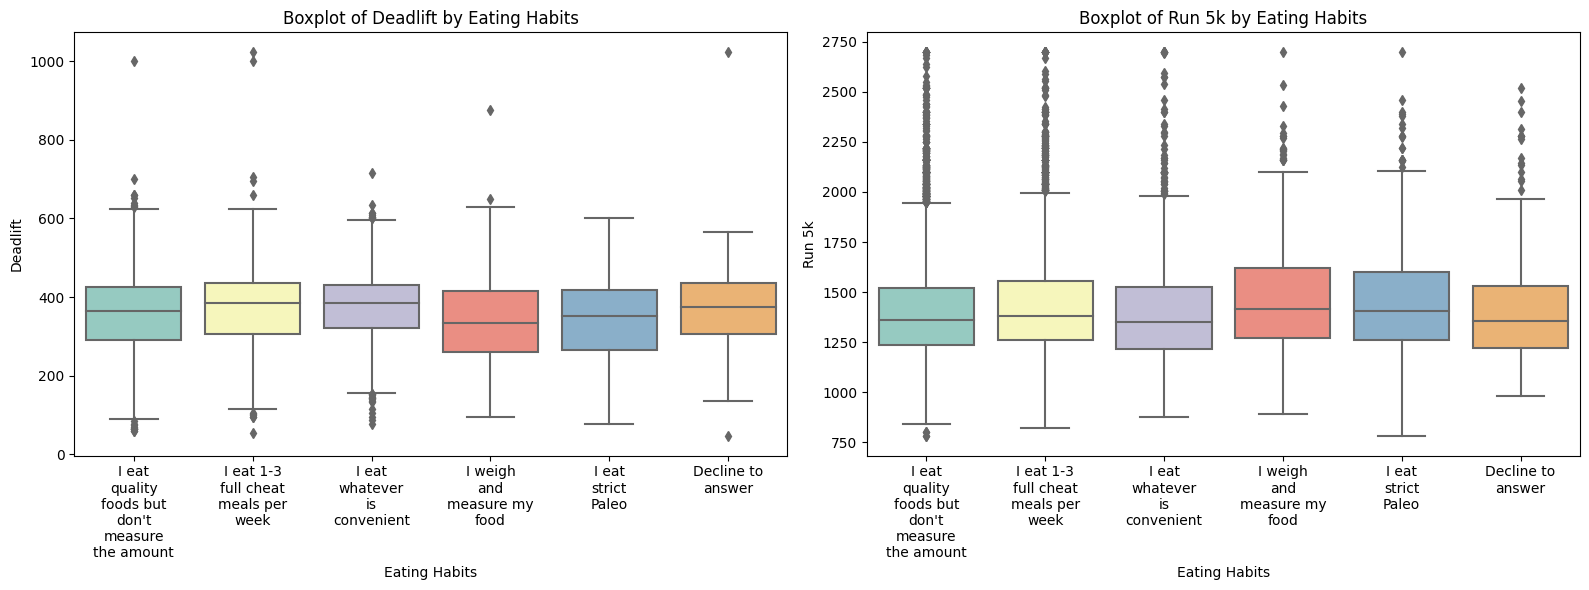

In [12]:
import textwrap

# Create a new column 'eating_habits' combining all eating habits for each athlete
athletes_clean['eating_habits'] = athletes_clean.filter(like='eat_').idxmax(axis=1).str.replace('eat_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['eating_habits'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'deadlift'
sns.boxplot(ax=axes[0], x='eating_habits', y='deadlift', data=athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Deadlift by Eating Habits')
axes[0].set_xlabel('Eating Habits')
axes[0].set_ylabel('Deadlift')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[1], x='eating_habits', y='run5k', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Run 5k by Eating Habits')
axes[1].set_xlabel('Eating Habits')
axes[1].set_ylabel('Run 5k')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

It doesn't look like the groups are that different, although they do overlap some anyway, which may provide some of the reason for that. 

##### Training

In [13]:
# Drop rows with NaN in 'train' column
athletes_clean = athletes_clean.dropna(subset=['train'])

# Split the values in the 'train' column by "|" and create dummy variables
dummy_train = pd.get_dummies(athletes_clean['train'].str.split('|', expand = True).stack(), prefix = 'train').groupby(level = 0).sum()

# Drop the column corresponding to the empty answer ('')
dummy_train = dummy_train.drop(columns = 'train_')

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_train], axis=1)

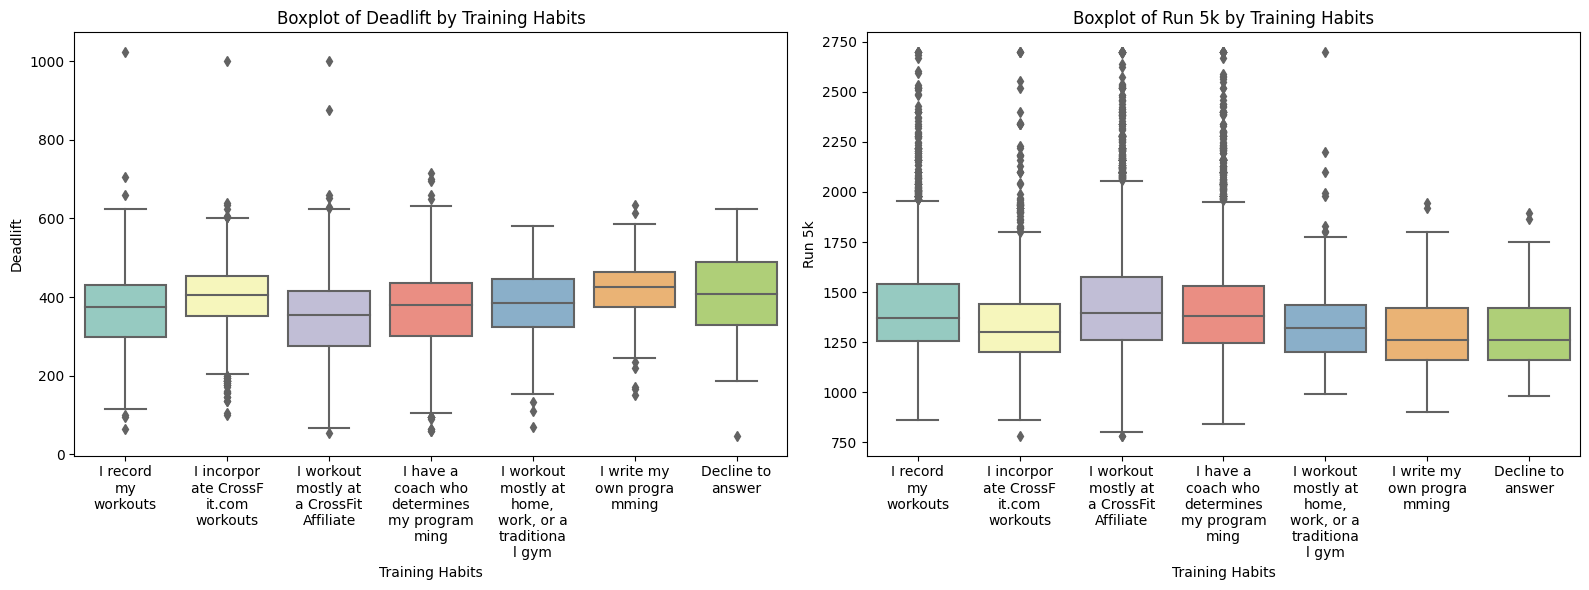

In [14]:
# Create a new column 'training_habits' combining all training habits for each athlete
athletes_clean['training_habits'] = athletes_clean.filter(like = 'train_').idxmax(axis=1).str.replace('train_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['training_habits'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'deadlift'
sns.boxplot(ax=axes[0], x='training_habits', y='deadlift', data=athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Deadlift by Training Habits')
axes[0].set_xlabel('Training Habits')
axes[0].set_ylabel('Deadlift')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[1], x='training_habits', y='run5k', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Run 5k by Training Habits')
axes[1].set_xlabel('Training Habits')
axes[1].set_ylabel('Run 5k')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

##### Athletic background

In [15]:
# Drop rows with NaN in 'train' column
athletes_clean = athletes_clean.dropna(subset = ['background'])

# Split the values in the 'train' column by "|" and create dummy variables
dummy_background = pd.get_dummies(athletes_clean['background'].str.split('|', expand = True).stack(), prefix = 'background').groupby(level = 0).sum()

# Drop the column corresponding to the empty answer ('')
dummy_background = dummy_background.drop(columns = 'background_')

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_background], axis = 1)

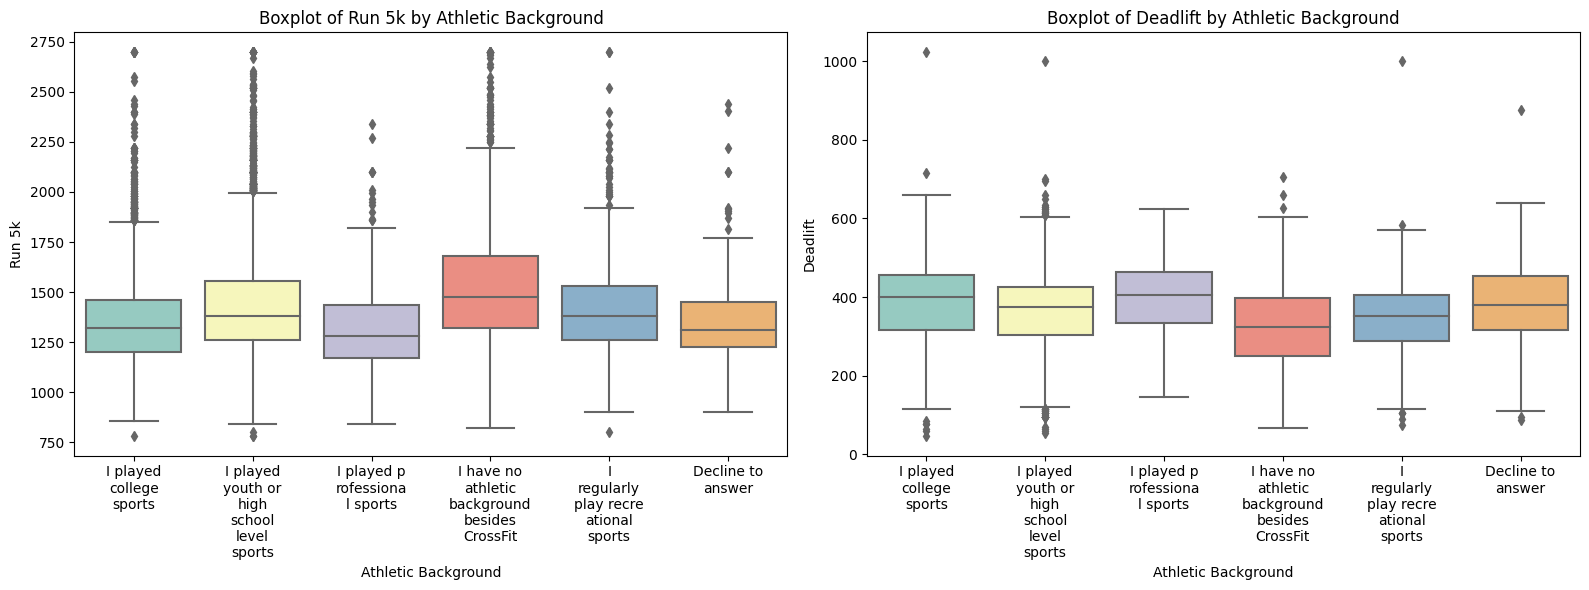

In [16]:
# Create a new column 'training_habits' combining all training habits for each athlete
athletes_clean['athletic_bg'] = athletes_clean.filter(like = 'background_').idxmax(axis=1).str.replace('background_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['athletic_bg'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[0], x='athletic_bg', y='run5k', data=athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Run 5k by Athletic Background')
axes[0].set_xlabel('Athletic Background')
axes[0].set_ylabel('Run 5k')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'deadlift'
sns.boxplot(ax=axes[1], x='athletic_bg', y='deadlift', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Deadlift by Athletic Background')
axes[1].set_xlabel('Athletic Background')
axes[1].set_ylabel('Deadlift')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

##### Crossfit experience

In [17]:
# Drop rows with NaN in 'experience' column
athletes_clean = athletes_clean.dropna(subset = ['experience'])

# Split the values in the 'experience' column by "|" and create dummy variables
dummy_experience = pd.get_dummies(athletes_clean['experience'].str.split('|', expand = True).stack(), prefix = 'experience').groupby(level = 0).sum()

# Drop the column corresponding to the empty answer ('')
dummy_experience = dummy_experience.drop(columns = 'experience_')

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_experience], axis = 1)

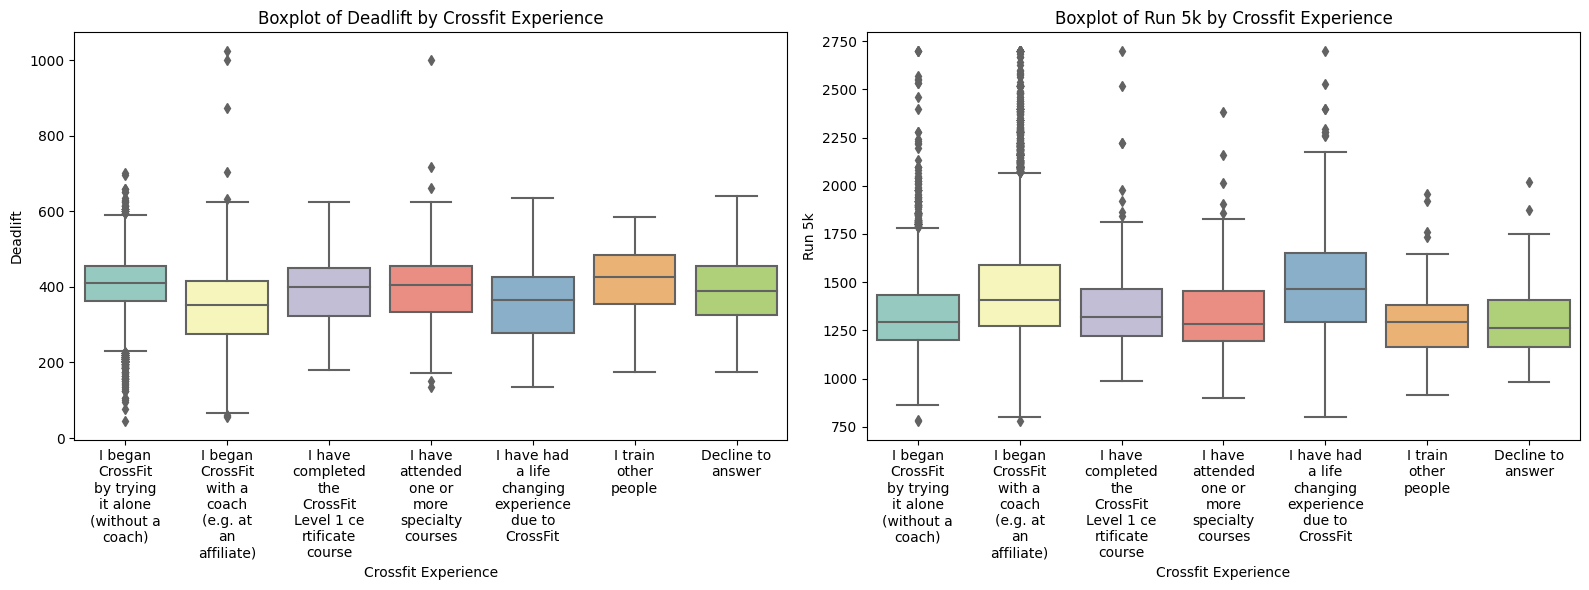

In [18]:
# Create a new column 'crossfit_experience' combining all training habits for each athlete
athletes_clean['crossfit_experience'] = athletes_clean.filter(like = 'experience_').idxmax(axis=1).str.replace('experience_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['crossfit_experience'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'deadlift'
sns.boxplot(ax=axes[0], x = 'crossfit_experience', y = 'deadlift', data=athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Deadlift by Crossfit Experience')
axes[0].set_xlabel('Crossfit Experience')
axes[0].set_ylabel('Deadlift')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[1], x='crossfit_experience', y='run5k', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Run 5k by Crossfit Experience')
axes[1].set_xlabel('Crossfit Experience')
axes[1].set_ylabel('Run 5k')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

##### Training schedule

In [19]:
# Drop rows with NaN in 'train' column
athletes_clean = athletes_clean.dropna(subset = ['schedule'])

# Split the values in the 'train' column by "|" and create dummy variables
dummy_schedule = pd.get_dummies(athletes_clean['schedule'].str.split('|', expand = True).stack(), prefix = 'schedule').groupby(level = 0).sum()

# Drop the column corresponding to the empty answer ('')
dummy_schedule = dummy_schedule.drop(columns = 'schedule_')

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_schedule], axis = 1)

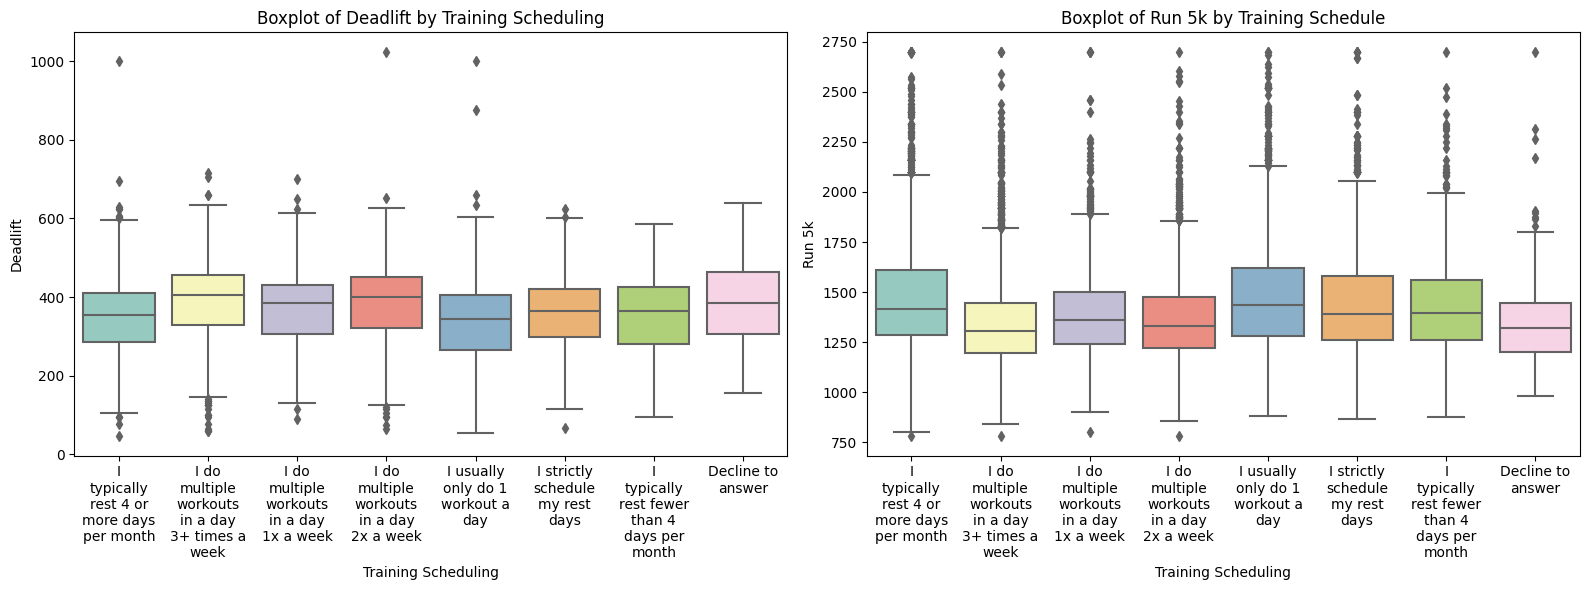

In [20]:
# Create a new column 'training_schedule' combining all training schedules for each athlete
athletes_clean['training_schedule'] = athletes_clean.filter(like = 'schedule_').idxmax(axis=1).str.replace('schedule_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['training_schedule'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'deadlift'
sns.boxplot(ax = axes[0], x = 'training_schedule', y = 'deadlift', data = athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Deadlift by Training Scheduling')
axes[0].set_xlabel('Training Scheduling')
axes[0].set_ylabel('Deadlift')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[1], x='training_schedule', y='run5k', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Run 5k by Training Schedule')
axes[1].set_xlabel('Training Scheduling')
axes[1].set_ylabel('Run 5k')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

##### How long have they been training

In [21]:
# Drop rows with NaN in 'train' column
athletes_clean = athletes_clean.dropna(subset = ['howlong'])

def find_longest_training(row):
    if pd.isna(row):
        return np.nan
    
    weights = {'Less than 6 months': 1, '6-12 months': 2, '1-2 years': 3, '2-4 years': 4, '4+ years': 5}
    
    categories = row.split('|')
    return max(categories, key = lambda x: weights.get(x, 0))

# Create a new column 'howlong_group' based on the longest category
athletes_clean['howlong_group'] = athletes_clean['howlong'].apply(find_longest_training)

# Split the values in the 'train' column by "|" and create dummy variables
dummy_howlong = pd.get_dummies(athletes_clean['howlong_group'].str.split('|', expand = True).stack(), prefix = 'howlong').groupby(level = 0).sum()

# Concatenate the original DataFrame with the dummy variables
athletes_clean = pd.concat([athletes_clean, dummy_howlong], axis = 1)

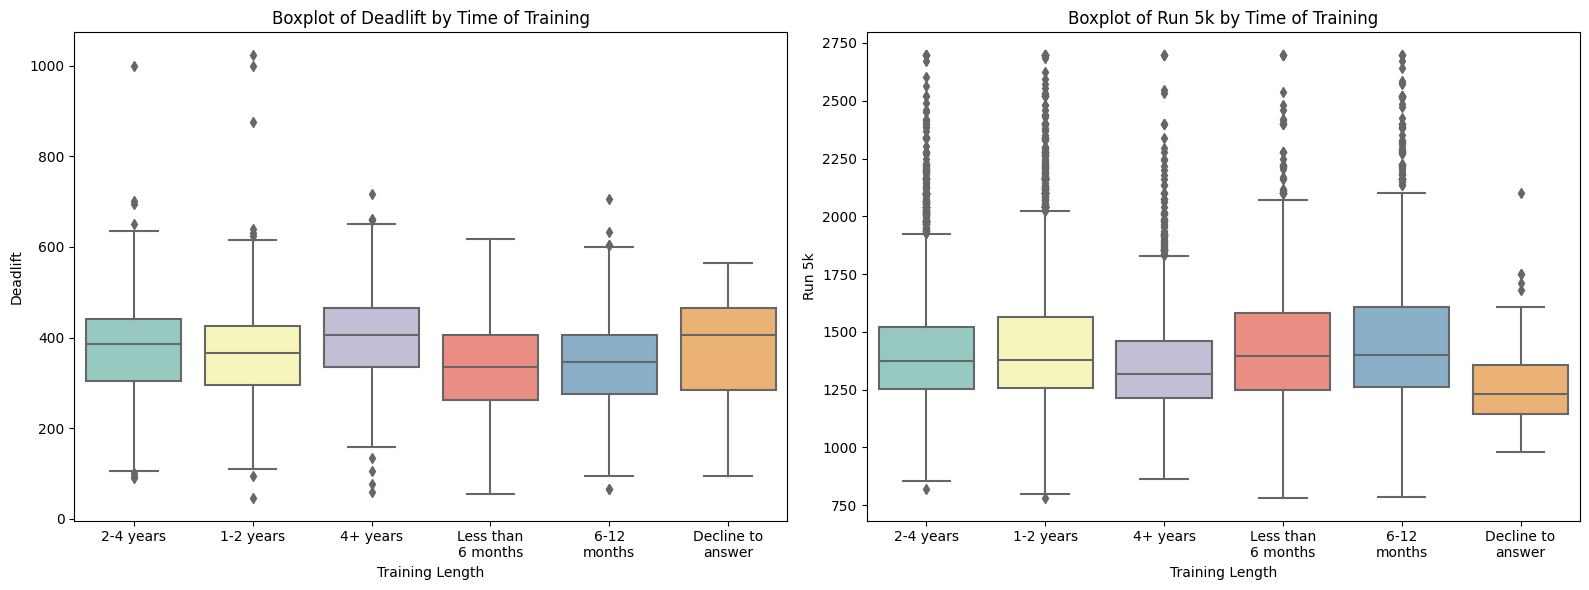

In [22]:
# Create a new column 'training_schedule' combining all training schedules for each athlete
athletes_clean['training_length'] = athletes_clean.filter(like = 'howlong_').drop('howlong_group', axis = 1).idxmax(axis=1).str.replace('howlong_', '')

# Wrap x-axis labels onto a second line if they are long
wrapped_labels = [textwrap.fill(label, width=10) for label in athletes_clean['training_length'].unique()]

# Create subplots with two boxplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot boxplot for 'deadlift'
sns.boxplot(ax = axes[0], x = 'training_length', y = 'deadlift', data = athletes_clean, palette='Set3')
axes[0].set_title('Boxplot of Deadlift by Time of Training')
axes[0].set_xlabel('Training Length')
axes[0].set_ylabel('Deadlift')
axes[0].set_xticks(range(len(wrapped_labels)))
axes[0].set_xticklabels(wrapped_labels, rotation=0, ha='center')

# Plot boxplot for 'run5k'
sns.boxplot(ax=axes[1], x='training_length', y='run5k', data=athletes_clean, palette='Set3')
axes[1].set_title('Boxplot of Run 5k by Time of Training')
axes[1].set_xlabel('Training Length')
axes[1].set_ylabel('Run 5k')
axes[1].set_xticks(range(len(wrapped_labels)))
axes[1].set_xticklabels(wrapped_labels, rotation=0, ha='center')

plt.tight_layout()
plt.show()

# Model

#### Deadlift

In [23]:
deadlift_nuts = athletes_clean.sample(n = 2000)
# Make predictors for model
deadlift_x = deadlift_nuts.loc[:, ['age', 'age_squared', 'height', 'weight', 'Female', 'Male', 'eat_Decline to answer', 'eat_I eat 1-3 full cheat meals per week', 
                                    "eat_I eat quality foods but don't measure the amount", 'eat_I eat strict Paleo', 'eat_I eat whatever is convenient', 
                                    'eat_I weigh and measure my food', 'train_Decline to answer', 'train_I have a coach who determines my programming', 
                                    'train_I incorporate CrossFit.com workouts', 'train_I record my workouts', 'train_I workout mostly at a CrossFit Affiliate', 
                                    'train_I workout mostly at home, work, or a traditional gym', 'train_I write my own programming', 
                                    'background_Decline to answer', 'background_I have no athletic background besides CrossFit', 'background_I played college sports',
                                    'background_I played professional sports', 'background_I played youth or high school level sports', 
                                    'background_I regularly play recreational sports', 'experience_I began CrossFit by trying it alone (without a coach)',
                                    'experience_I began CrossFit with a coach (e.g. at an affiliate)', 'experience_I have attended one or more specialty courses',
                                    'experience_I have completed the CrossFit Level 1 certificate course', 'experience_I have had a life changing experience due to CrossFit',
                                    'experience_I train other people', 'schedule_Decline to answer',
                                    'schedule_I do multiple workouts in a day 1x a week',
                                    'schedule_I do multiple workouts in a day 2x a week',
                                    'schedule_I do multiple workouts in a day 3+ times a week',
                                    'schedule_I strictly schedule my rest days',
                                    'schedule_I typically rest 4 or more days per month',
                                    'schedule_I typically rest fewer than 4 days per month',
                                    'schedule_I usually only do 1 workout a day',
                                    'howlong_1-2 years',
                                    'howlong_2-4 years', 'howlong_4+ years', 'howlong_6-12 months',
                                    'howlong_Decline to answer', 'howlong_Less than 6 months']].apply(pd.to_numeric, errors='coerce')

# Make response variable for model
deadlift_y = deadlift_nuts.deadlift.to_numpy()

In [24]:
k = deadlift_x.shape[1]

with pm.Model() as deadlift_model:
    # Priors for coefficients
    beta = pm.Normal('beta', mu = 0, sigma = 10, shape = k)
    sigma = pm.HalfNormal('sigma', sigma = 10)

    # Intercept
    alpha = pm.Normal('alpha', mu = 0, sigma = 10)

    # Linear regression model
    mu = pm.Deterministic('mu', alpha + pm.math.dot(deadlift_x, beta))
    
    # Likelihood
    y = pm.Normal('y', mu = mu, sigma = sigma, observed = deadlift_y)

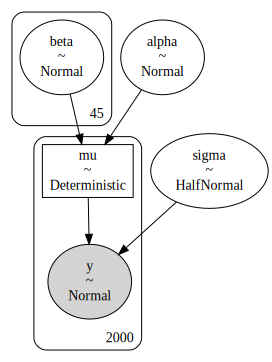

In [26]:
# Graphical representation
pm.model_to_graphviz(deadlift_model)

In [ ]:
with deadlift_model:
    deadlift_trace = pm.sample(2000, tune = 1000, random_seed = 31958, return_inferencedata = False)

In [73]:
deadlift_pp = pm.sample_posterior_predictive(deadlift_trace, model = deadlift_model)
deadlift_inference = pm.to_inference_data(trace = deadlift_trace, model = deadlift_model, log_likelihood = True)

Sampling: [y]


c:\Users\brown\miniconda3\envs\DSenv\lib\site-packages\arviz\plots\traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (46), generating only 20 plots
  warnings.warn(


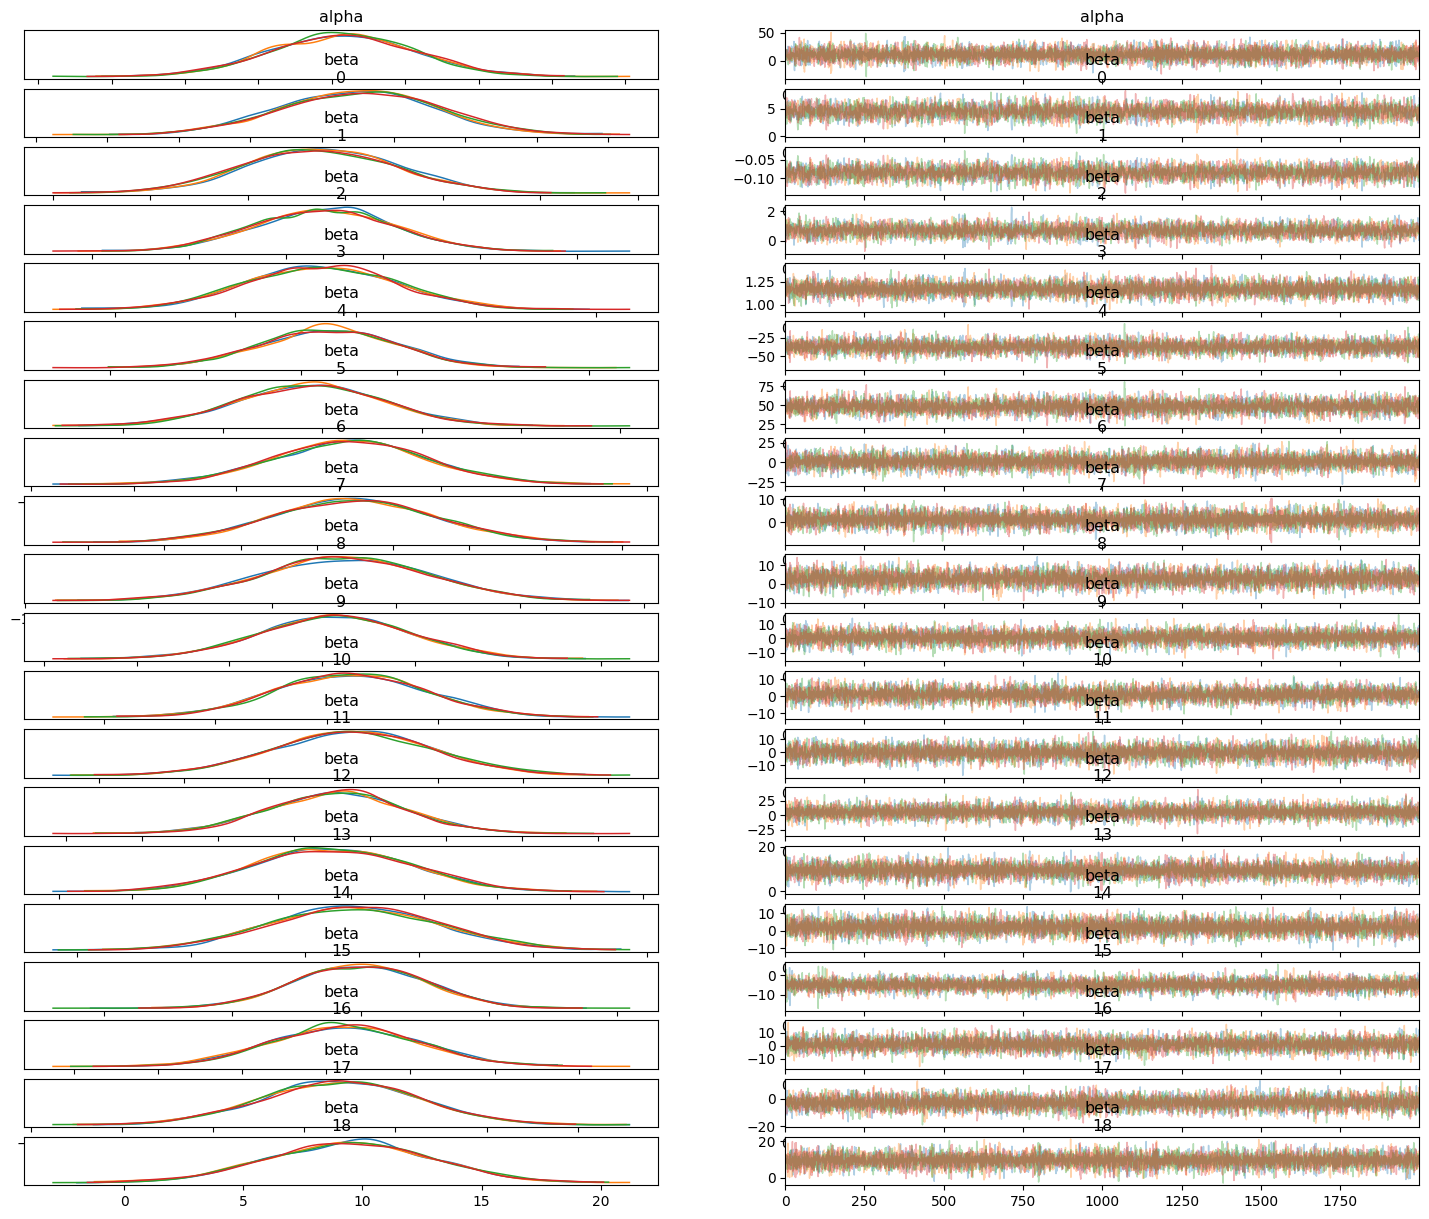

In [74]:
az.plot_trace(deadlift_inference, compact = False, var_names = ['alpha', 'beta'], figsize = (18, 15));

In [63]:
az.summary(deadlift_inference, var_names = ['alpha', 'beta'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha     11.435  9.820  -7.847   28.895      0.077    0.081   16406.0   
beta[0]    4.520  1.080   2.391    6.446      0.015    0.010    5318.0   
beta[1]   -0.085  0.015  -0.113   -0.055      0.000    0.000    5363.0   
beta[2]    0.695  0.359   0.035    1.370      0.005    0.003    5829.0   
beta[3]    1.171  0.062   1.055    1.287      0.001    0.000   11123.0   
beta[4]  -37.191  7.088 -50.959  -24.376      0.075    0.053    9027.0   
beta[5]   48.781  7.353  34.735   62.407      0.077    0.054    9193.0   
beta[6]    1.089  7.464 -12.652   15.611      0.062    0.088   14490.0   
beta[7]    1.201  2.646  -3.757    6.207      0.021    0.029   16560.0   
beta[8]    2.957  3.352  -3.284    9.262      0.035    0.030    8947.0   
beta[9]    0.679  4.024  -6.847    8.242      0.035    0.049   13588.0   
beta[10]   1.060  3.359  -5.059    7.536      0.033    0.033   10084.0   
beta[11]  -0.061  4.657  -8.645    8.927      0.046    0.049   10274.0   
beta[12]   5.613  9.056 -11.010   23.149      0.073    0.089   15484.0   
beta[13]   9.349  2.710   4.304   14.320      0.021    0.015   16699.0   
beta[14]   2.157  3.647  -5.080    8.594      0.027    0.034   17632.0   
beta[15]  -5.030  2.543  -9.753   -0.313      0.022    0.018   13104.0   
beta[16]   1.117  4.360  -7.059    9.270      0.041    0.044   11205.0   
beta[17]  -3.022  4.227 -11.145    4.739      0.041    0.039   10806.0   
beta[18]   9.455  3.486   2.782   15.819      0.029    0.024   14405.0   
beta[19]  12.115  7.951  -2.260   27.678      0.062    0.057   16292.0   
beta[20] -11.471  4.147 -19.107   -3.746      0.042    0.030    9743.0   
beta[21]   8.729  2.767   3.509   13.931      0.023    0.017   14926.0   
beta[22]  14.499  5.779   3.515   25.471      0.046    0.037   15866.0   
beta[23]  -1.730  3.170  -7.796    4.015      0.030    0.028   11358.0   
beta[24]   1.178  2.633  -3.883    6.020      0.024    0.029   12022.0   
beta[25]   2.353  4.690  -6.288   11.377      0.050    0.044    8715.0   
beta[26] -10.836  4.595 -19.412   -2.072      0.051    0.037    8109.0   
beta[27]   6.080  3.533  -0.655   12.603      0.032    0.027   12398.0   
beta[28]  16.889  3.706   9.882   23.725      0.033    0.024   12341.0   
beta[29]  -3.265  2.637  -8.140    1.654      0.022    0.021   14443.0   
beta[30]   1.057  3.829  -6.281    8.179      0.035    0.040   11957.0   
beta[31]   0.503  8.242 -15.776   15.279      0.071    0.100   13533.0   
beta[32]   5.306  3.907  -2.152   12.323      0.036    0.030   11650.0   
beta[33]   8.995  3.679   1.840   15.675      0.038    0.028    9368.0   
beta[34]  15.813  3.722   8.987   22.932      0.042    0.030    8038.0   
beta[35]   5.627  3.087  -0.245   11.242      0.024    0.022   15884.0   
beta[36]   0.318  2.575  -4.487    5.116      0.023    0.028   12903.0   
beta[37]   9.231  3.985   1.599   16.517      0.034    0.027   13701.0   
beta[38] -10.598  3.172 -16.366   -4.403      0.035    0.025    8211.0   
beta[39]   6.469  4.963  -3.075   15.423      0.078    0.055    4048.0   
beta[40]  16.385  4.989   7.075   25.590      0.078    0.055    4093.0   
beta[41]  30.175  5.382  20.463   40.498      0.078    0.055    4751.0   
beta[42] -11.987  5.264 -21.857   -2.365      0.077    0.054    4695.0   
beta[43]   5.443  9.168 -11.629   22.631      0.079    0.094   13577.0   
beta[44] -35.280  5.934 -46.199  -24.079      0.077    0.055    5977.0   

          ess_tail  r_hat  
alpha       6029.0    1.0  
beta[0]     5584.0    1.0  
beta[1]     5865.0    1.0  
beta[2]     5647.0    1.0  
beta[3]     6361.0    1.0  
beta[4]     6244.0    1.0  
beta[5]     6372.0    1.0  
beta[6]     5704.0    1.0  
beta[7]     5985.0    1.0  
beta[8]     6053.0    1.0  
beta[9]     5756.0    1.0  
beta[10]    5840.0    1.0  
beta[11]    6393.0    1.0  
beta[12]    6226.0    1.0  
beta[13]    5783.0    1.0  
beta[14]    6468.0    1.0  
beta[15]    6211.0    1.0  
beta[16]    6416.0    1.0  
b

The rhats and the trace plots show a well-converged model!

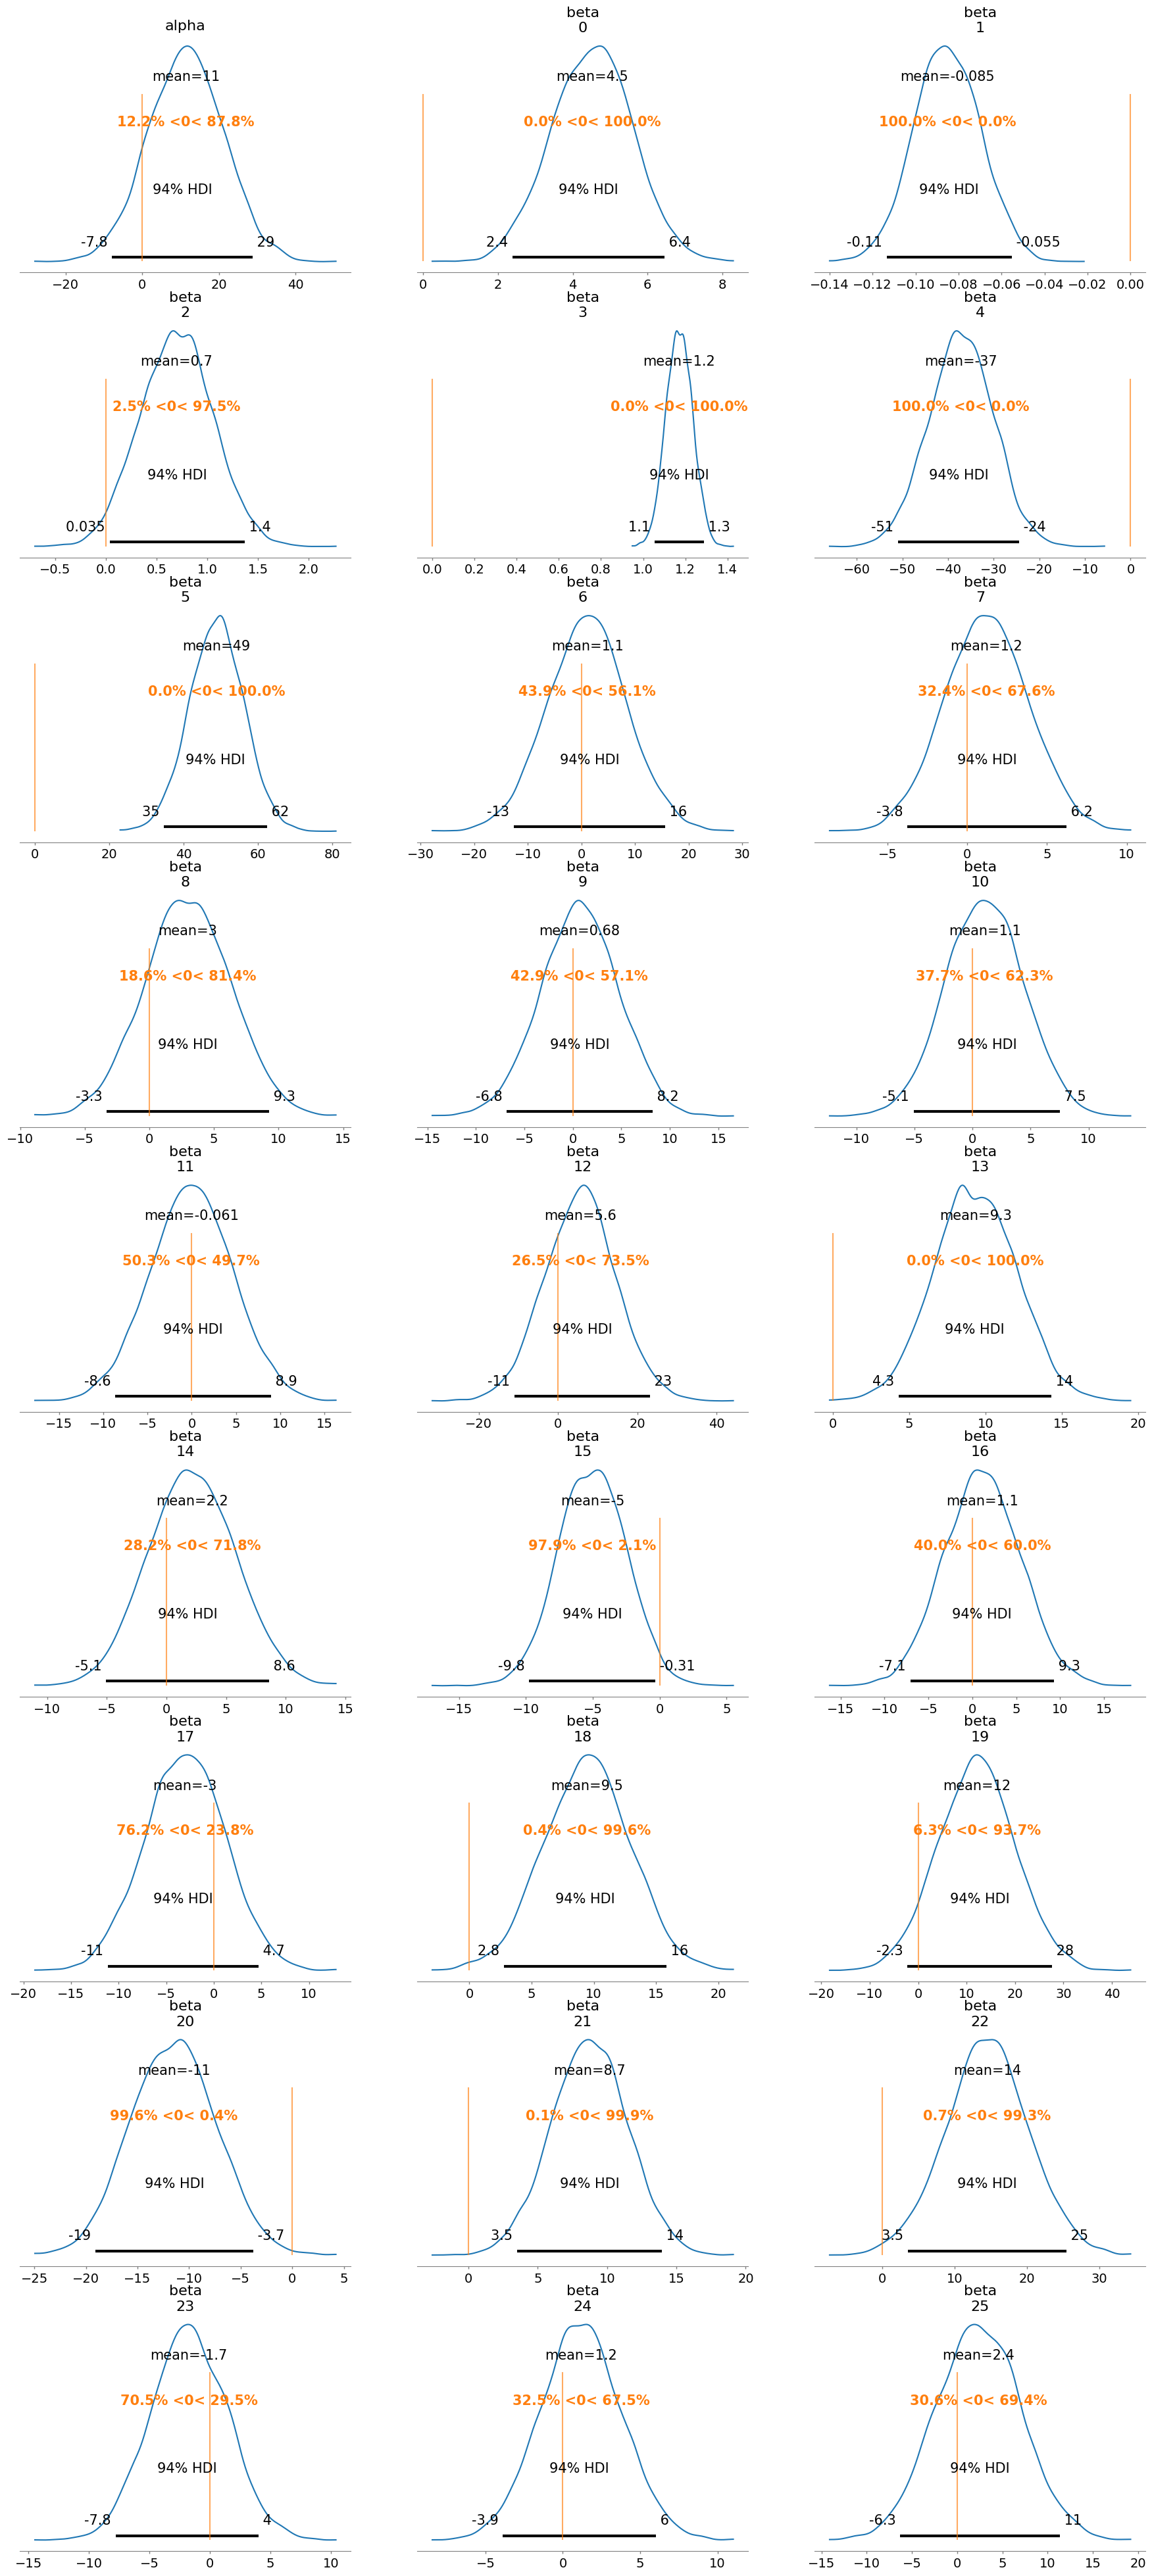

In [64]:
az.plot_posterior(
    deadlift_inference,
    var_names = ['alpha', 'beta'],
    ref_val = 0,
    coords = {'beta_dim_0': slice(0, 25)}
);

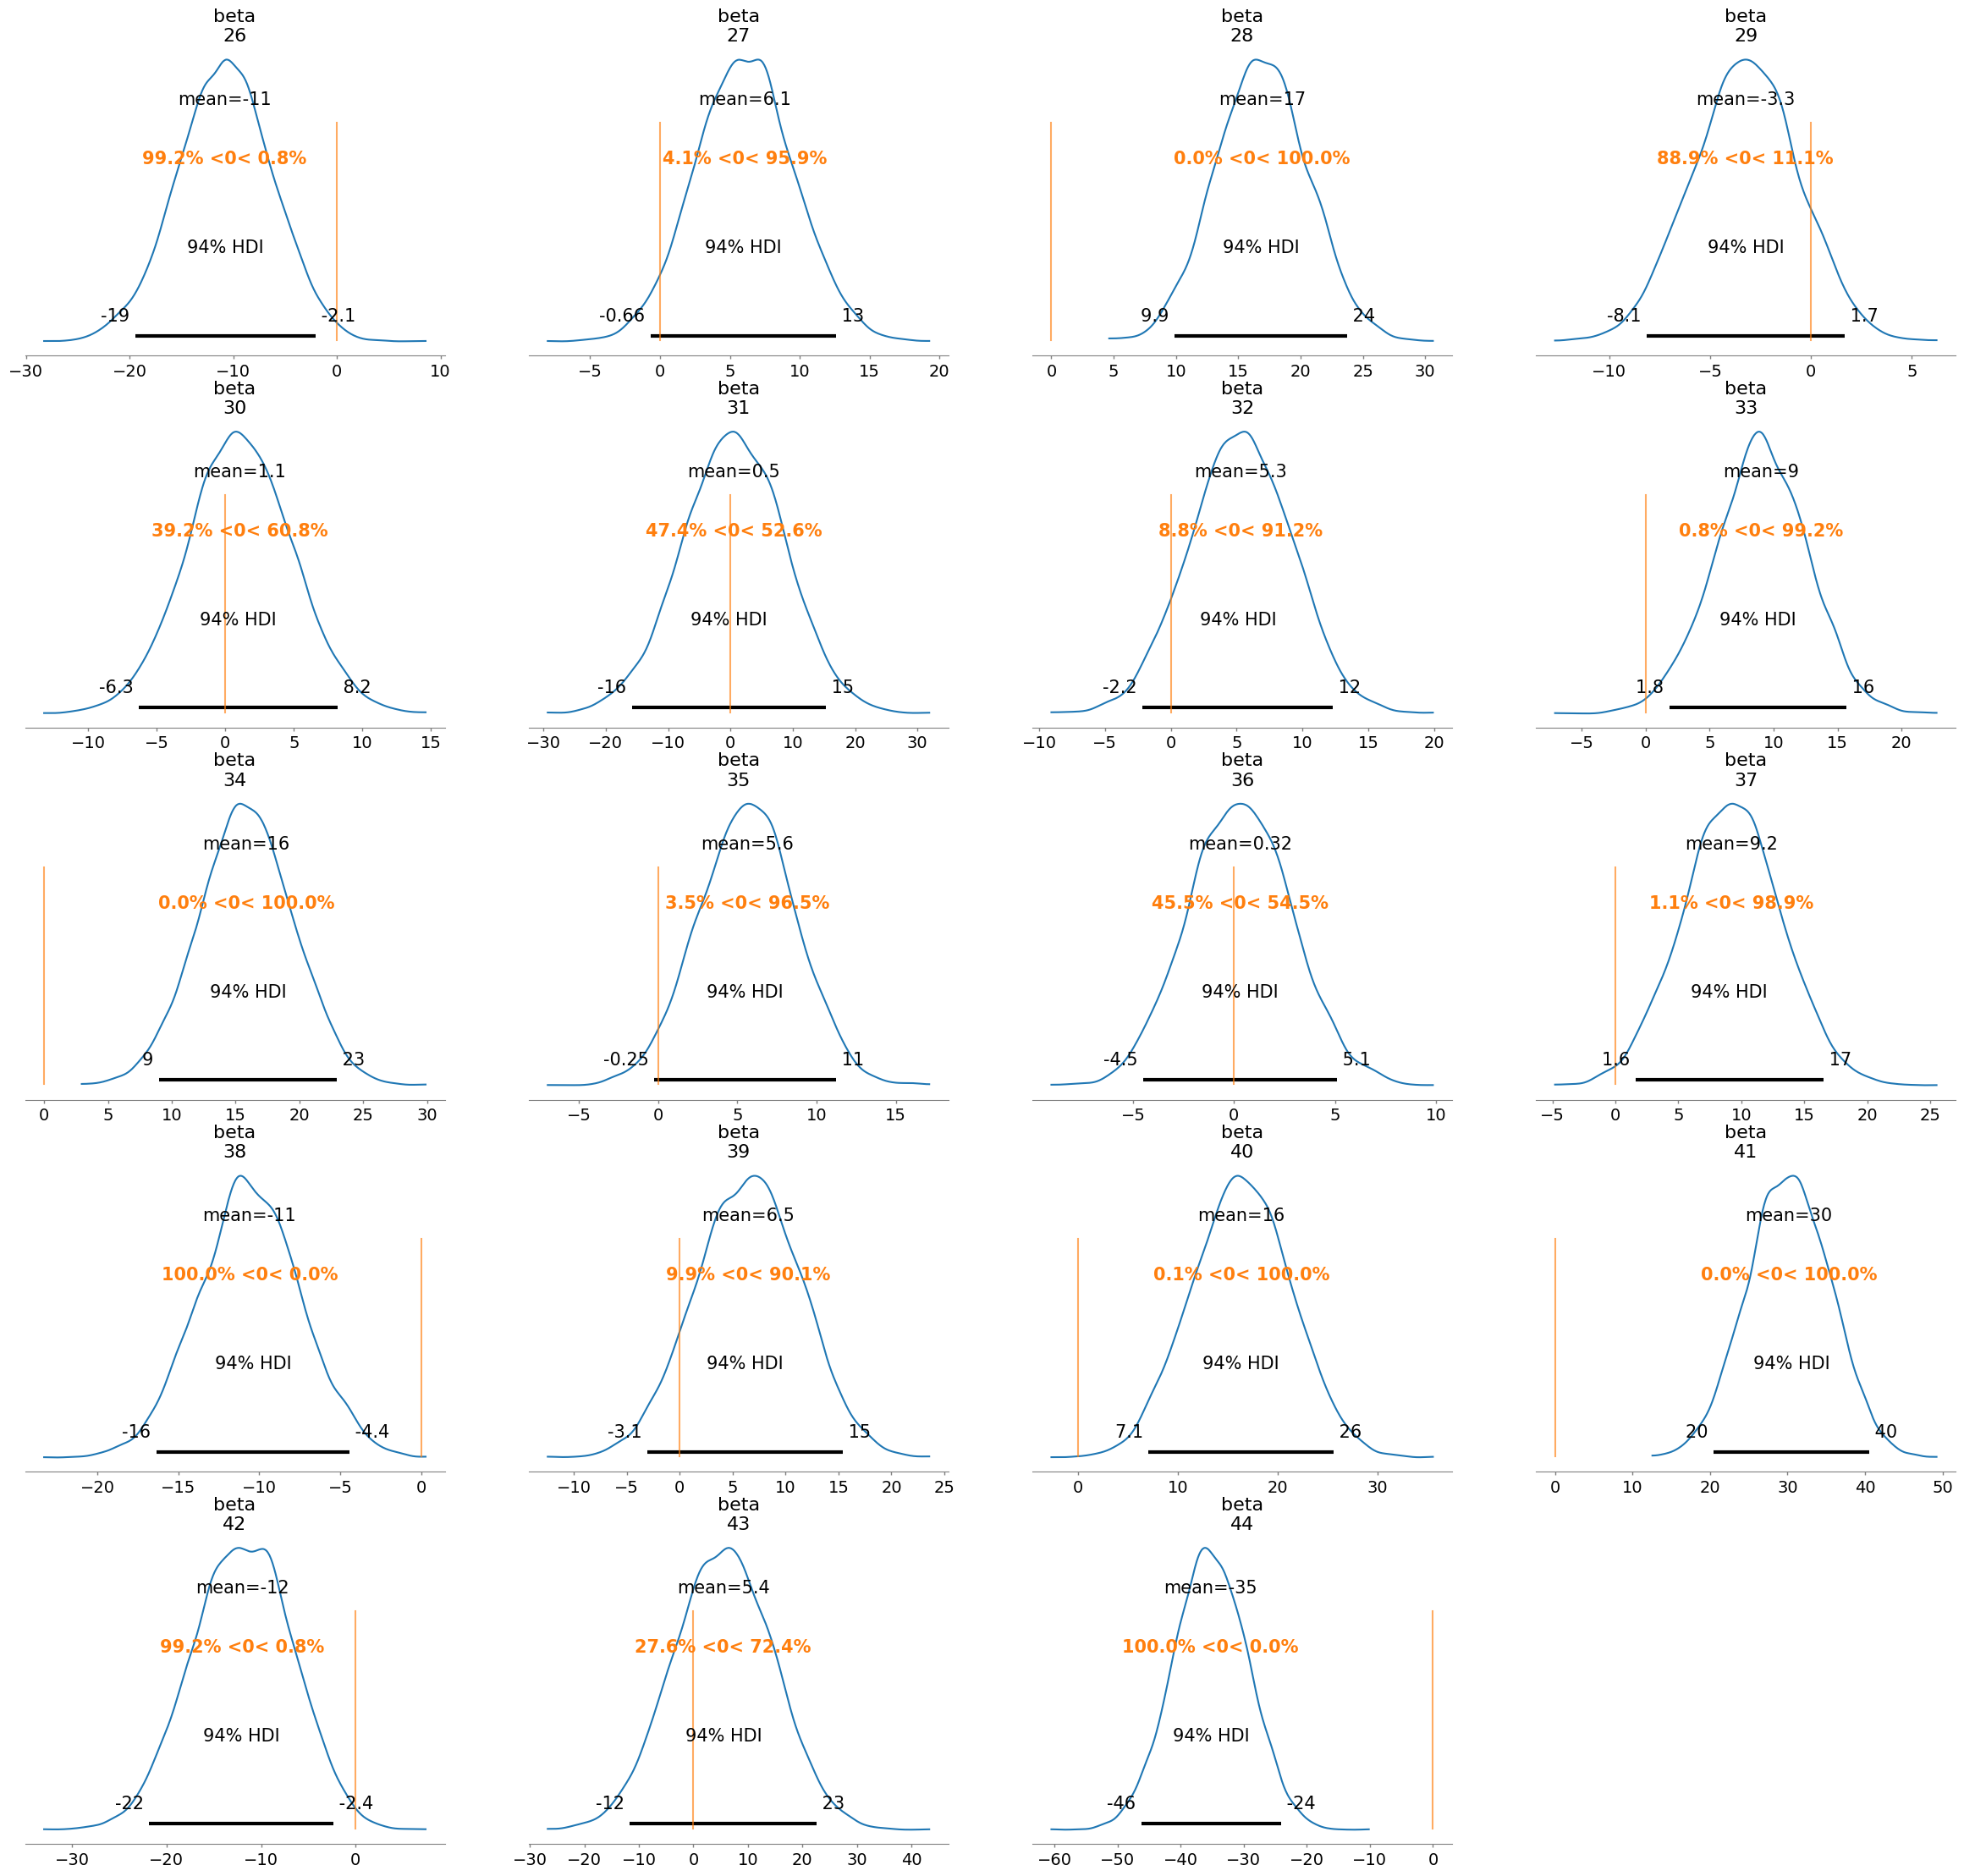

In [75]:
az.plot_posterior(
    deadlift_inference,
    var_names = ['beta'],
    ref_val = 0,
    coords = {'beta_dim_0': slice(26, 45)}
);

<Axes: title={'center': 'y / y'}>

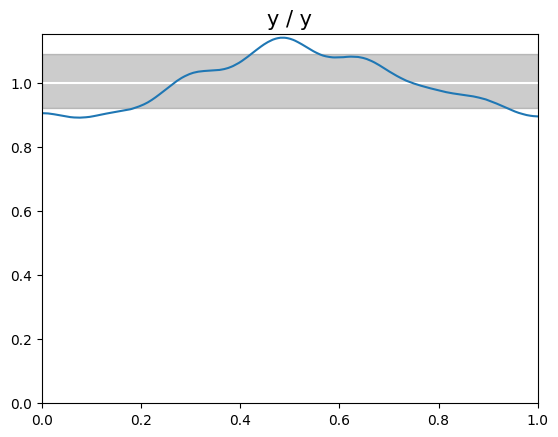

In [76]:
az.plot_bpv(deadlift_pp)

c:\Users\brown\miniconda3\envs\DSenv\lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\brown\miniconda3\envs\DSenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


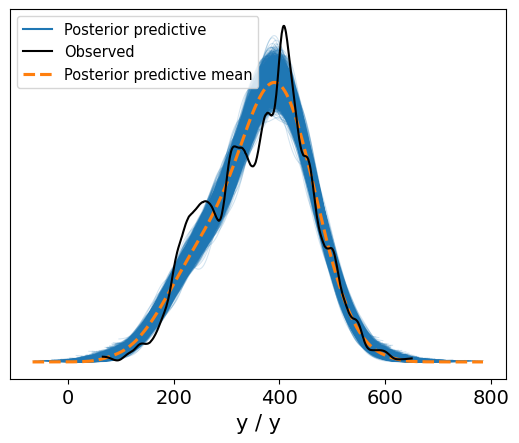

In [68]:
az.plot_ppc(deadlift_pp);

In [78]:
pm.waic(deadlift_inference)

c:\Users\brown\miniconda3\envs\DSenv\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 posterior samples and 2000 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10840.08    40.52
p_waic       38.02        -

There has been a warning during the calculation. Please check the results.

In [79]:
pm.loo(deadlift_inference)

Computed from 8000 posterior samples and 2000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -10840.15    40.53
p_loo       38.09        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2000  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

#### 5k Time

In [81]:
run_nuts = athletes_clean.sample(n = 2000)
# Make predictors for model
run_x = run_nuts.loc[:, ['age', 'age_squared', 'bmi', 'Female', 'Male', 'eat_Decline to answer', 'eat_I eat 1-3 full cheat meals per week', 
                              "eat_I eat quality foods but don't measure the amount", 'eat_I eat strict Paleo', 'eat_I eat whatever is convenient', 
                              'eat_I weigh and measure my food', 'train_Decline to answer', 'train_I have a coach who determines my programming', 
                              'train_I incorporate CrossFit.com workouts', 'train_I record my workouts', 'train_I workout mostly at a CrossFit Affiliate', 
                              'train_I workout mostly at home, work, or a traditional gym', 'train_I write my own programming', 
                              'background_Decline to answer', 'background_I have no athletic background besides CrossFit', 'background_I played college sports',
                              'background_I played professional sports', 'background_I played youth or high school level sports', 
                              'background_I regularly play recreational sports', 'experience_I began CrossFit by trying it alone (without a coach)',
                              'experience_I began CrossFit with a coach (e.g. at an affiliate)', 'experience_I have attended one or more specialty courses',
                              'experience_I have completed the CrossFit Level 1 certificate course', 'experience_I have had a life changing experience due to CrossFit',
                              'experience_I train other people', 'schedule_Decline to answer',
                              'schedule_I do multiple workouts in a day 1x a week',
                              'schedule_I do multiple workouts in a day 2x a week',
                              'schedule_I do multiple workouts in a day 3+ times a week',
                              'schedule_I strictly schedule my rest days',
                              'schedule_I typically rest 4 or more days per month',
                              'schedule_I typically rest fewer than 4 days per month',
                              'schedule_I usually only do 1 workout a day',
                              'howlong_1-2 years',
                              'howlong_2-4 years', 'howlong_4+ years', 'howlong_6-12 months',
                              'howlong_Decline to answer', 'howlong_Less than 6 months']].apply(pd.to_numeric, errors = 'coerce')

# Make response variable for model
run_y = run_nuts.run5k.to_numpy()

In [82]:
k = run_x.shape[1]

with pm.Model() as run_model:
    # Priors for coefficients
    beta = pm.Normal('beta', mu = 0, sigma = 100, shape = k)
    sigma = pm.HalfNormal('sigma', sigma = 100)

    # Intercept
    alpha = pm.Normal('alpha', mu = 0, sigma = 10)

    # Linear regression model
    mu = pm.Deterministic('mu', alpha + pm.math.dot(run_x, beta))

    # Likelihood
    y = pm.SkewNormal('y', alpha = 5, mu = mu, sigma = sigma, observed = run_y)

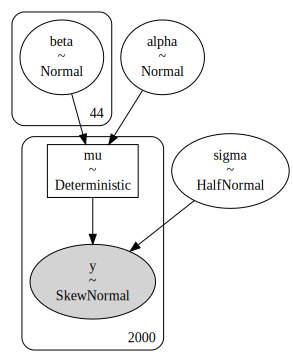

In [83]:
# Graphical representation
pm.model_to_graphviz(run_model)

In [ ]:
with run_model:
    run_trace = pm.sample(2000, tune = 1000, random_seed = 31958, return_inferencedata = False)

In [85]:
run_pp = pm.sample_posterior_predictive(run_trace, model = run_model)
run_inference = pm.to_inference_data(trace = run_trace, model = run_model, log_likelihood = True)

Sampling: [y]


c:\Users\brown\miniconda3\envs\DSenv\lib\site-packages\arviz\plots\traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (45), generating only 20 plots
  warnings.warn(


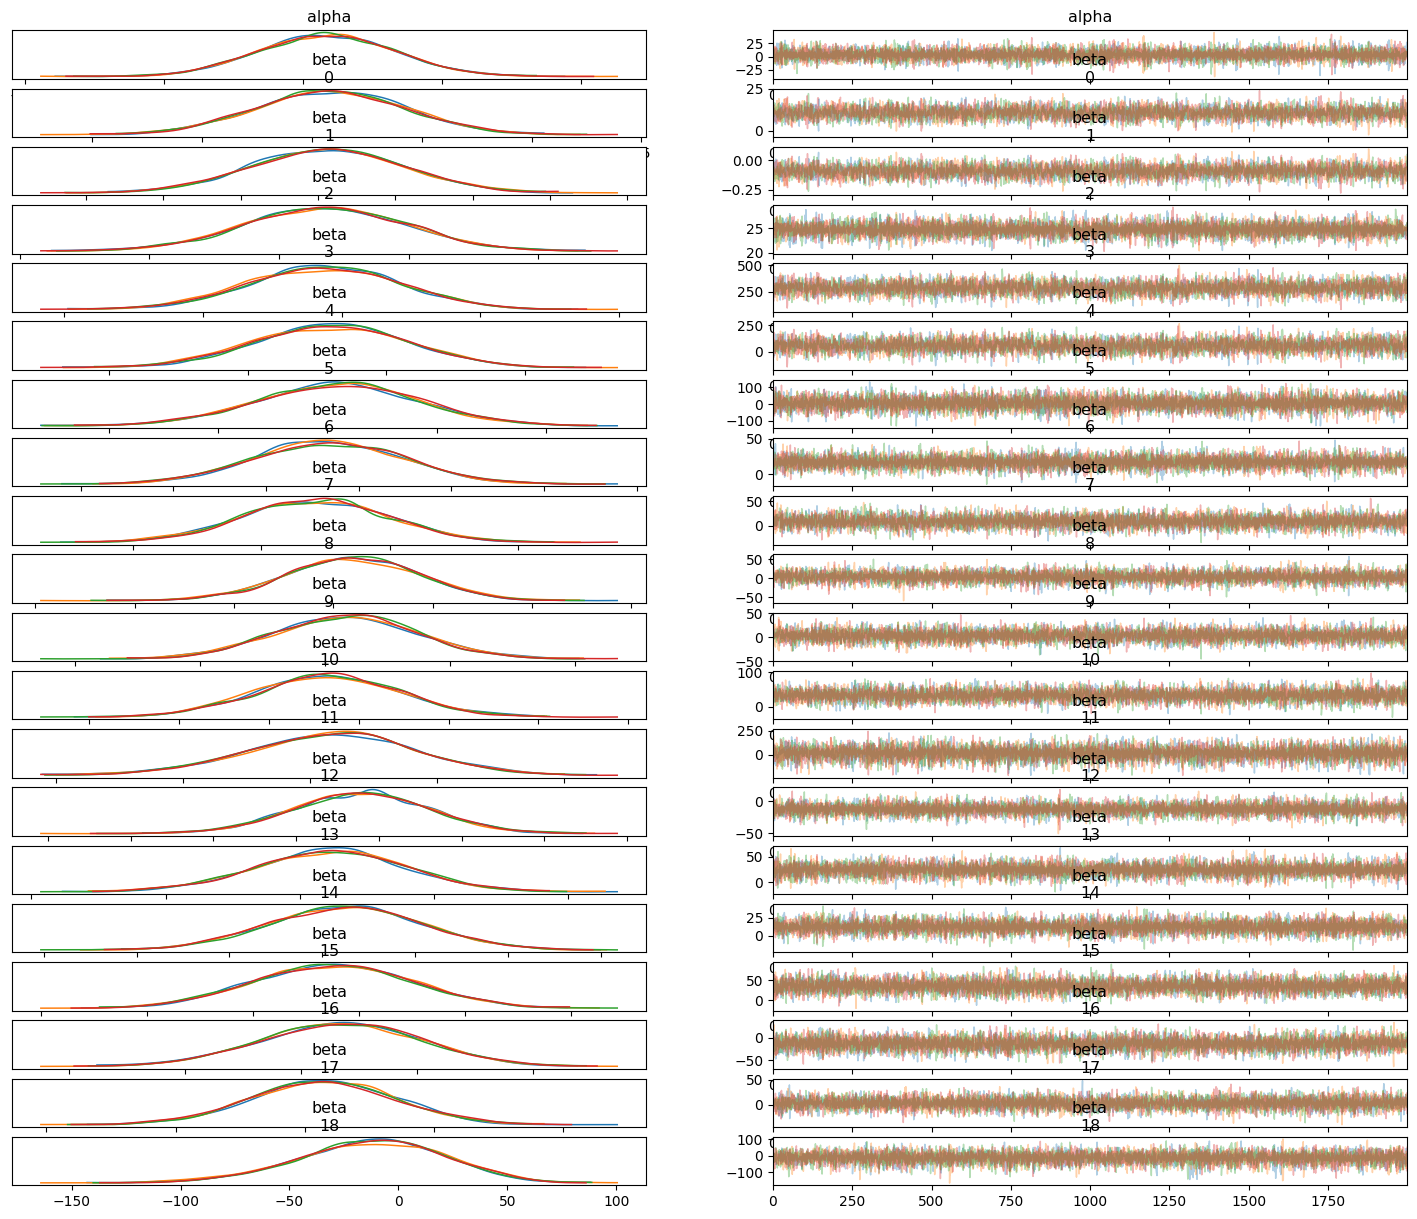

In [87]:
az.plot_trace(run_inference, compact = False, var_names = ['alpha', 'beta'], figsize = (18, 15));

In [88]:
az.summary(run_inference, var_names = ['alpha', 'beta'])

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha       3.434   9.825  -15.663   20.864      0.071    0.120   19134.0   
beta[0]    10.846   3.394    4.606   17.251      0.049    0.035    4781.0   
beta[1]    -0.094   0.049   -0.188   -0.003      0.001    0.000    4969.0   
beta[2]    24.709   1.254   22.338   27.066      0.011    0.008   13874.0   
beta[3]   287.337  54.560  182.449  386.374      0.731    0.517    5580.0   
beta[4]    60.046  55.408  -45.237  161.004      0.724    0.519    5867.0   
beta[5]     4.683  37.126  -66.192   74.273      0.341    0.415   11923.0   
beta[6]    16.732   8.136    1.013   31.408      0.071    0.060   12912.0   
beta[7]     8.434  11.438  -13.429   29.519      0.125    0.101    8393.0   
beta[8]     3.808  13.340  -21.232   29.077      0.127    0.150   11072.0   
beta[9]     3.327  11.347  -17.350   25.554      0.112    0.115   10346.0   
beta[10]   33.068  16.131    3.080   63.715      0.160    0.122   10183.0   
beta[11]   15.988  66.606 -105.385  148.774      0.551    0.726   14760.0   
beta[12]  -12.157   8.256  -27.078    3.829      0.065    0.059   16174.0   
beta[13]   24.521  11.269    2.415   45.199      0.091    0.074   15443.0   
beta[14]   12.503   8.192   -3.122   27.484      0.071    0.063   13153.0   
beta[15]   35.098  14.858    8.210   63.871      0.139    0.105   11510.0   
beta[16]  -13.169  13.738  -38.057   13.225      0.124    0.113   12215.0   
beta[17]    2.814  11.069  -18.360   23.467      0.100    0.122   12274.0   
beta[18]  -13.037  34.066  -75.652   51.437      0.301    0.373   14062.0   
beta[19]   77.299  13.628   52.366  102.816      0.132    0.095   10598.0   
beta[20]  -34.469   8.559  -50.379  -18.543      0.073    0.055   13837.0   
beta[21]  -57.970  17.809  -91.159  -24.844      0.138    0.110   16629.0   
beta[22]   28.683  10.320    9.099   47.966      0.099    0.072   10829.0   
beta[23]   12.547   8.013   -2.516   27.637      0.062    0.055   16806.0   
beta[24]   16.085  18.409  -19.000   50.614      0.193    0.162    9055.0   
beta[25]   45.282  17.887   11.144   78.488      0.188    0.140    9083.0   
beta[26]    1.774  12.084  -20.436   25.041      0.104    0.144   13601.0   
beta[27]   -5.606  11.558  -26.226   17.262      0.112    0.117   10747.0   
beta[28]    9.874   8.366   -6.001   25.828      0.067    0.067   15489.0   
beta[29]  -30.078  12.513  -53.581   -6.978      0.119    0.089   11074.0   
beta[30] -112.310  43.819 -192.355  -29.543      0.351    0.301   15873.0   
beta[31]   -5.388  13.323  -29.703   19.930      0.124    0.138   11646.0   
beta[32]  -25.440  12.543  -49.772   -2.803      0.136    0.100    8503.0   
beta[33]  -49.004  12.627  -73.096  -25.703      0.141    0.101    8011.0   
beta[34]  -16.342   9.744  -35.212    1.116      0.079    0.069   15224.0   
beta[35]  -11.777   8.175  -27.406    3.564      0.071    0.060   13197.0   
beta[36]  -32.042  11.920  -53.009   -8.103      0.101    0.078   13969.0   
beta[37]   13.486  10.467   -6.509   33.075      0.116    0.085    8171.0   
beta[38]   83.874  39.909    9.291  158.939      0.727    0.514    3012.0   
beta[39]   50.242  40.056  -25.749  124.363      0.731    0.517    3004.0   
beta[40]   51.181  40.764  -25.481  126.327      0.728    0.515    3134.0   
beta[41]   97.842  40.453   22.202  172.435      0.736    0.521    3020.0   
beta[42]   -3.656  68.141 -125.613  128.749      0.731    0.704    8717.0   
beta[43]   69.374  41.571   -6.428  149.315      0.749    0.529    3081.0   

          ess_tail  r_hat  
alpha       5186.0    1.0  
beta[0]     5482.0    1.0  
beta[1]     5290.0    1.0  
beta[2]     5764.0    1.0  
beta[3]     5534.0    1.0  
beta[4]     5774.0    1.0  
beta[5]     5972.0    1.0  
beta[6]     6097.0    1.0  
beta[7]     6640.0    1.0  
beta[8]     6092.0    1.0  
beta[9]     6404.0    1.0  
beta[10]    6551.0    1.0  
beta[11]    6623.0    1.0  
beta[12]    5847.0    1.0  
beta[13]    5846.0    1.0  
beta[14]    6023.0    

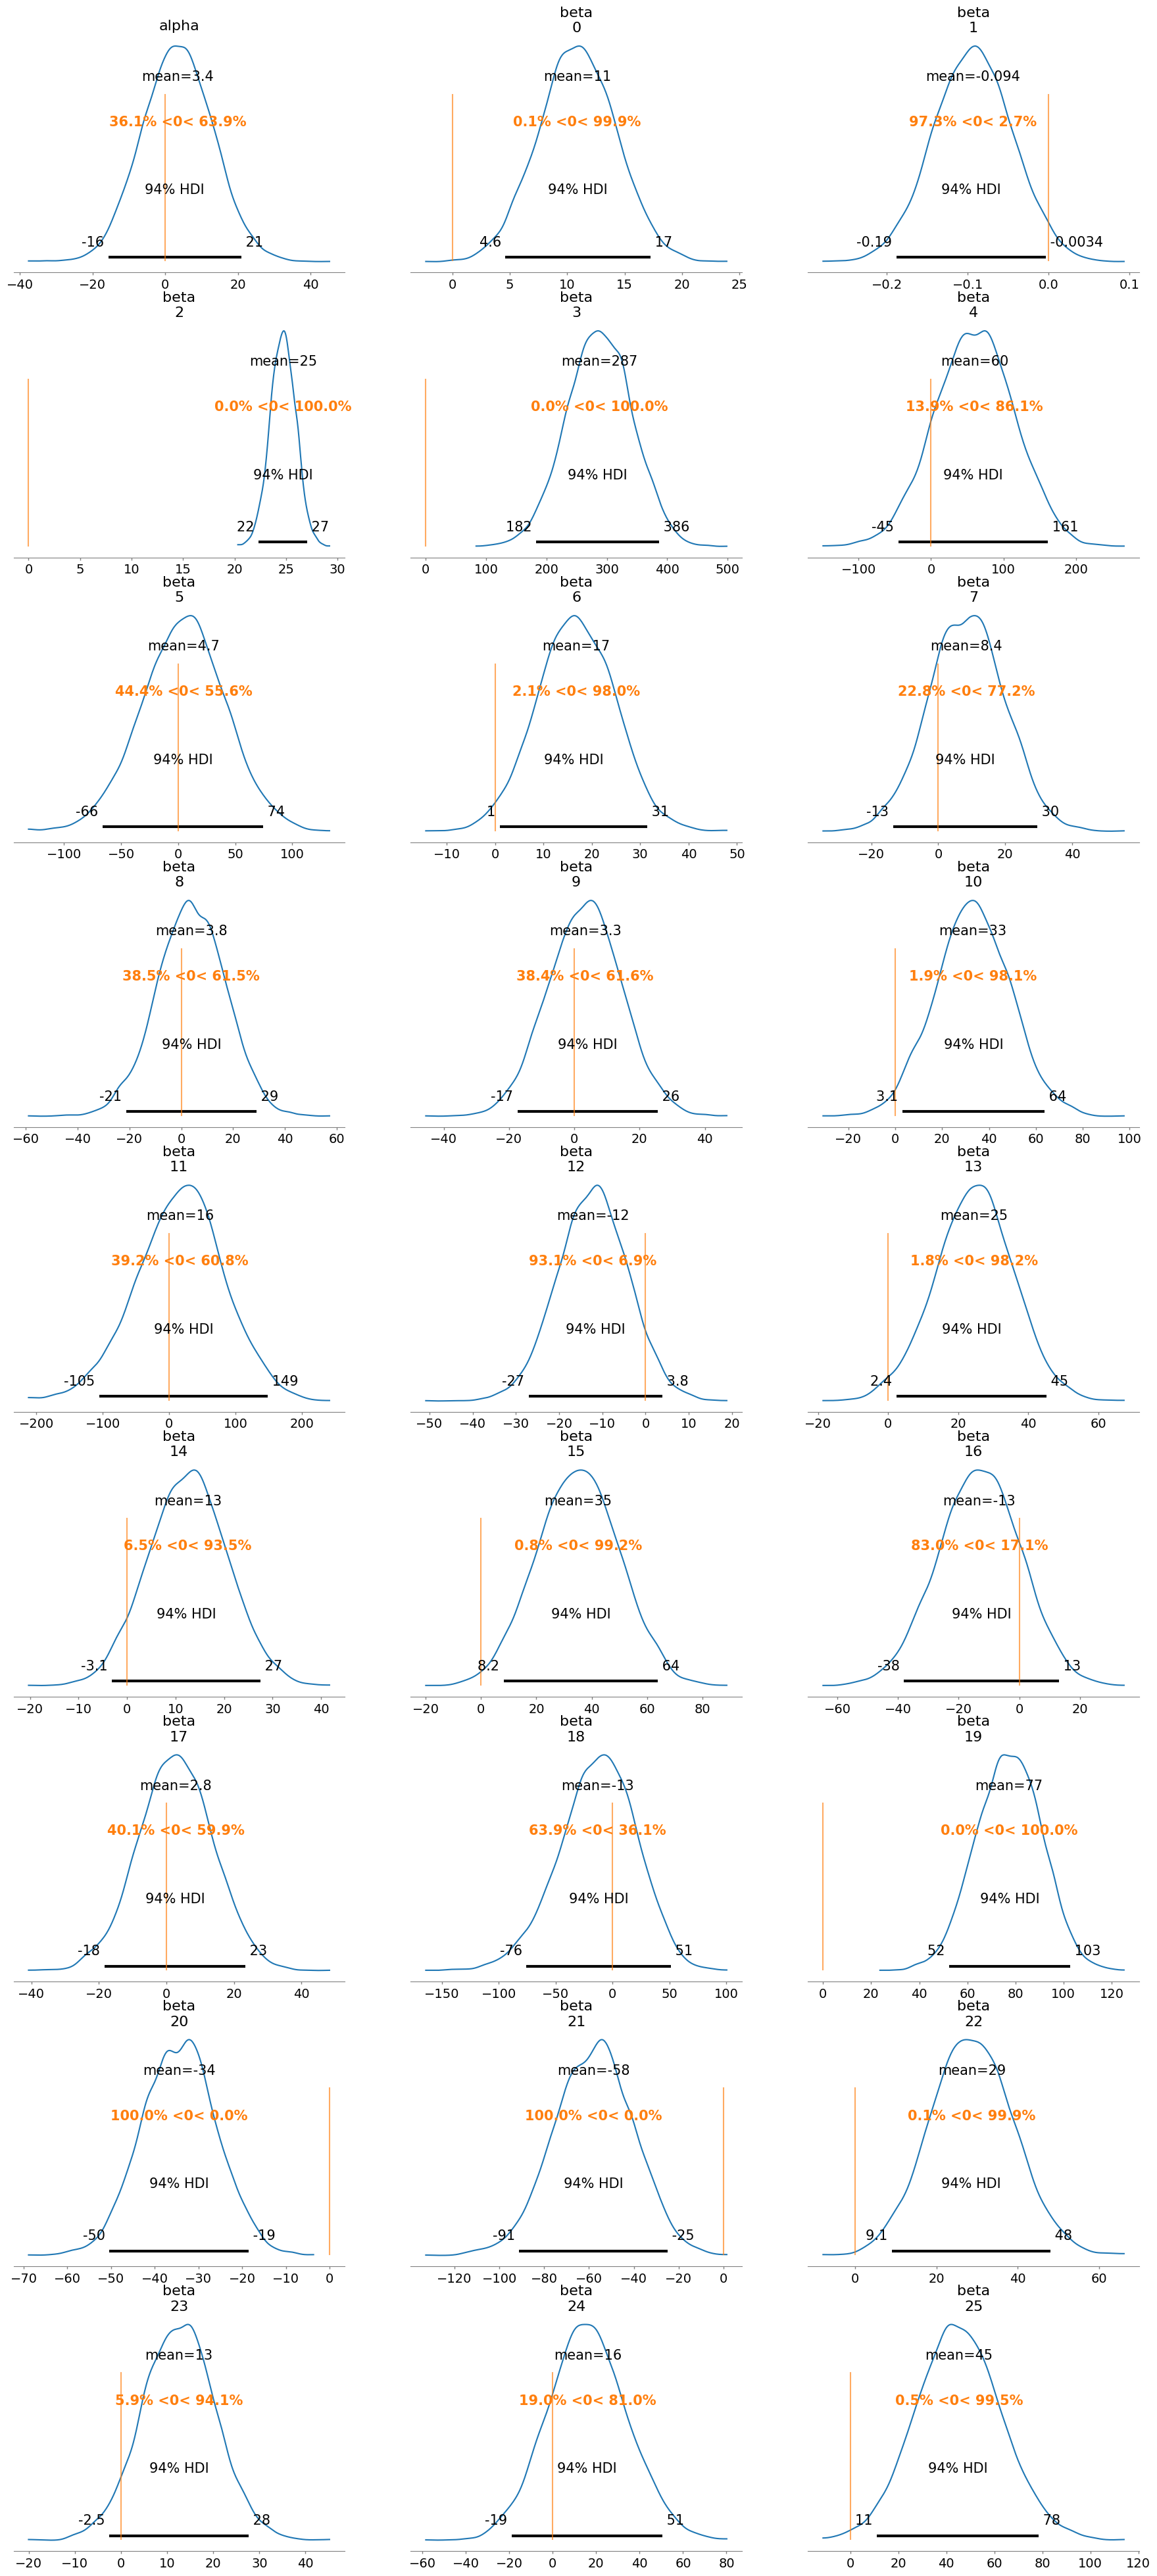

In [89]:
az.plot_posterior(
    run_inference,
    var_names=['alpha', 'beta'],
    ref_val=0,
    coords={'beta_dim_0': slice(0, 25)}
);

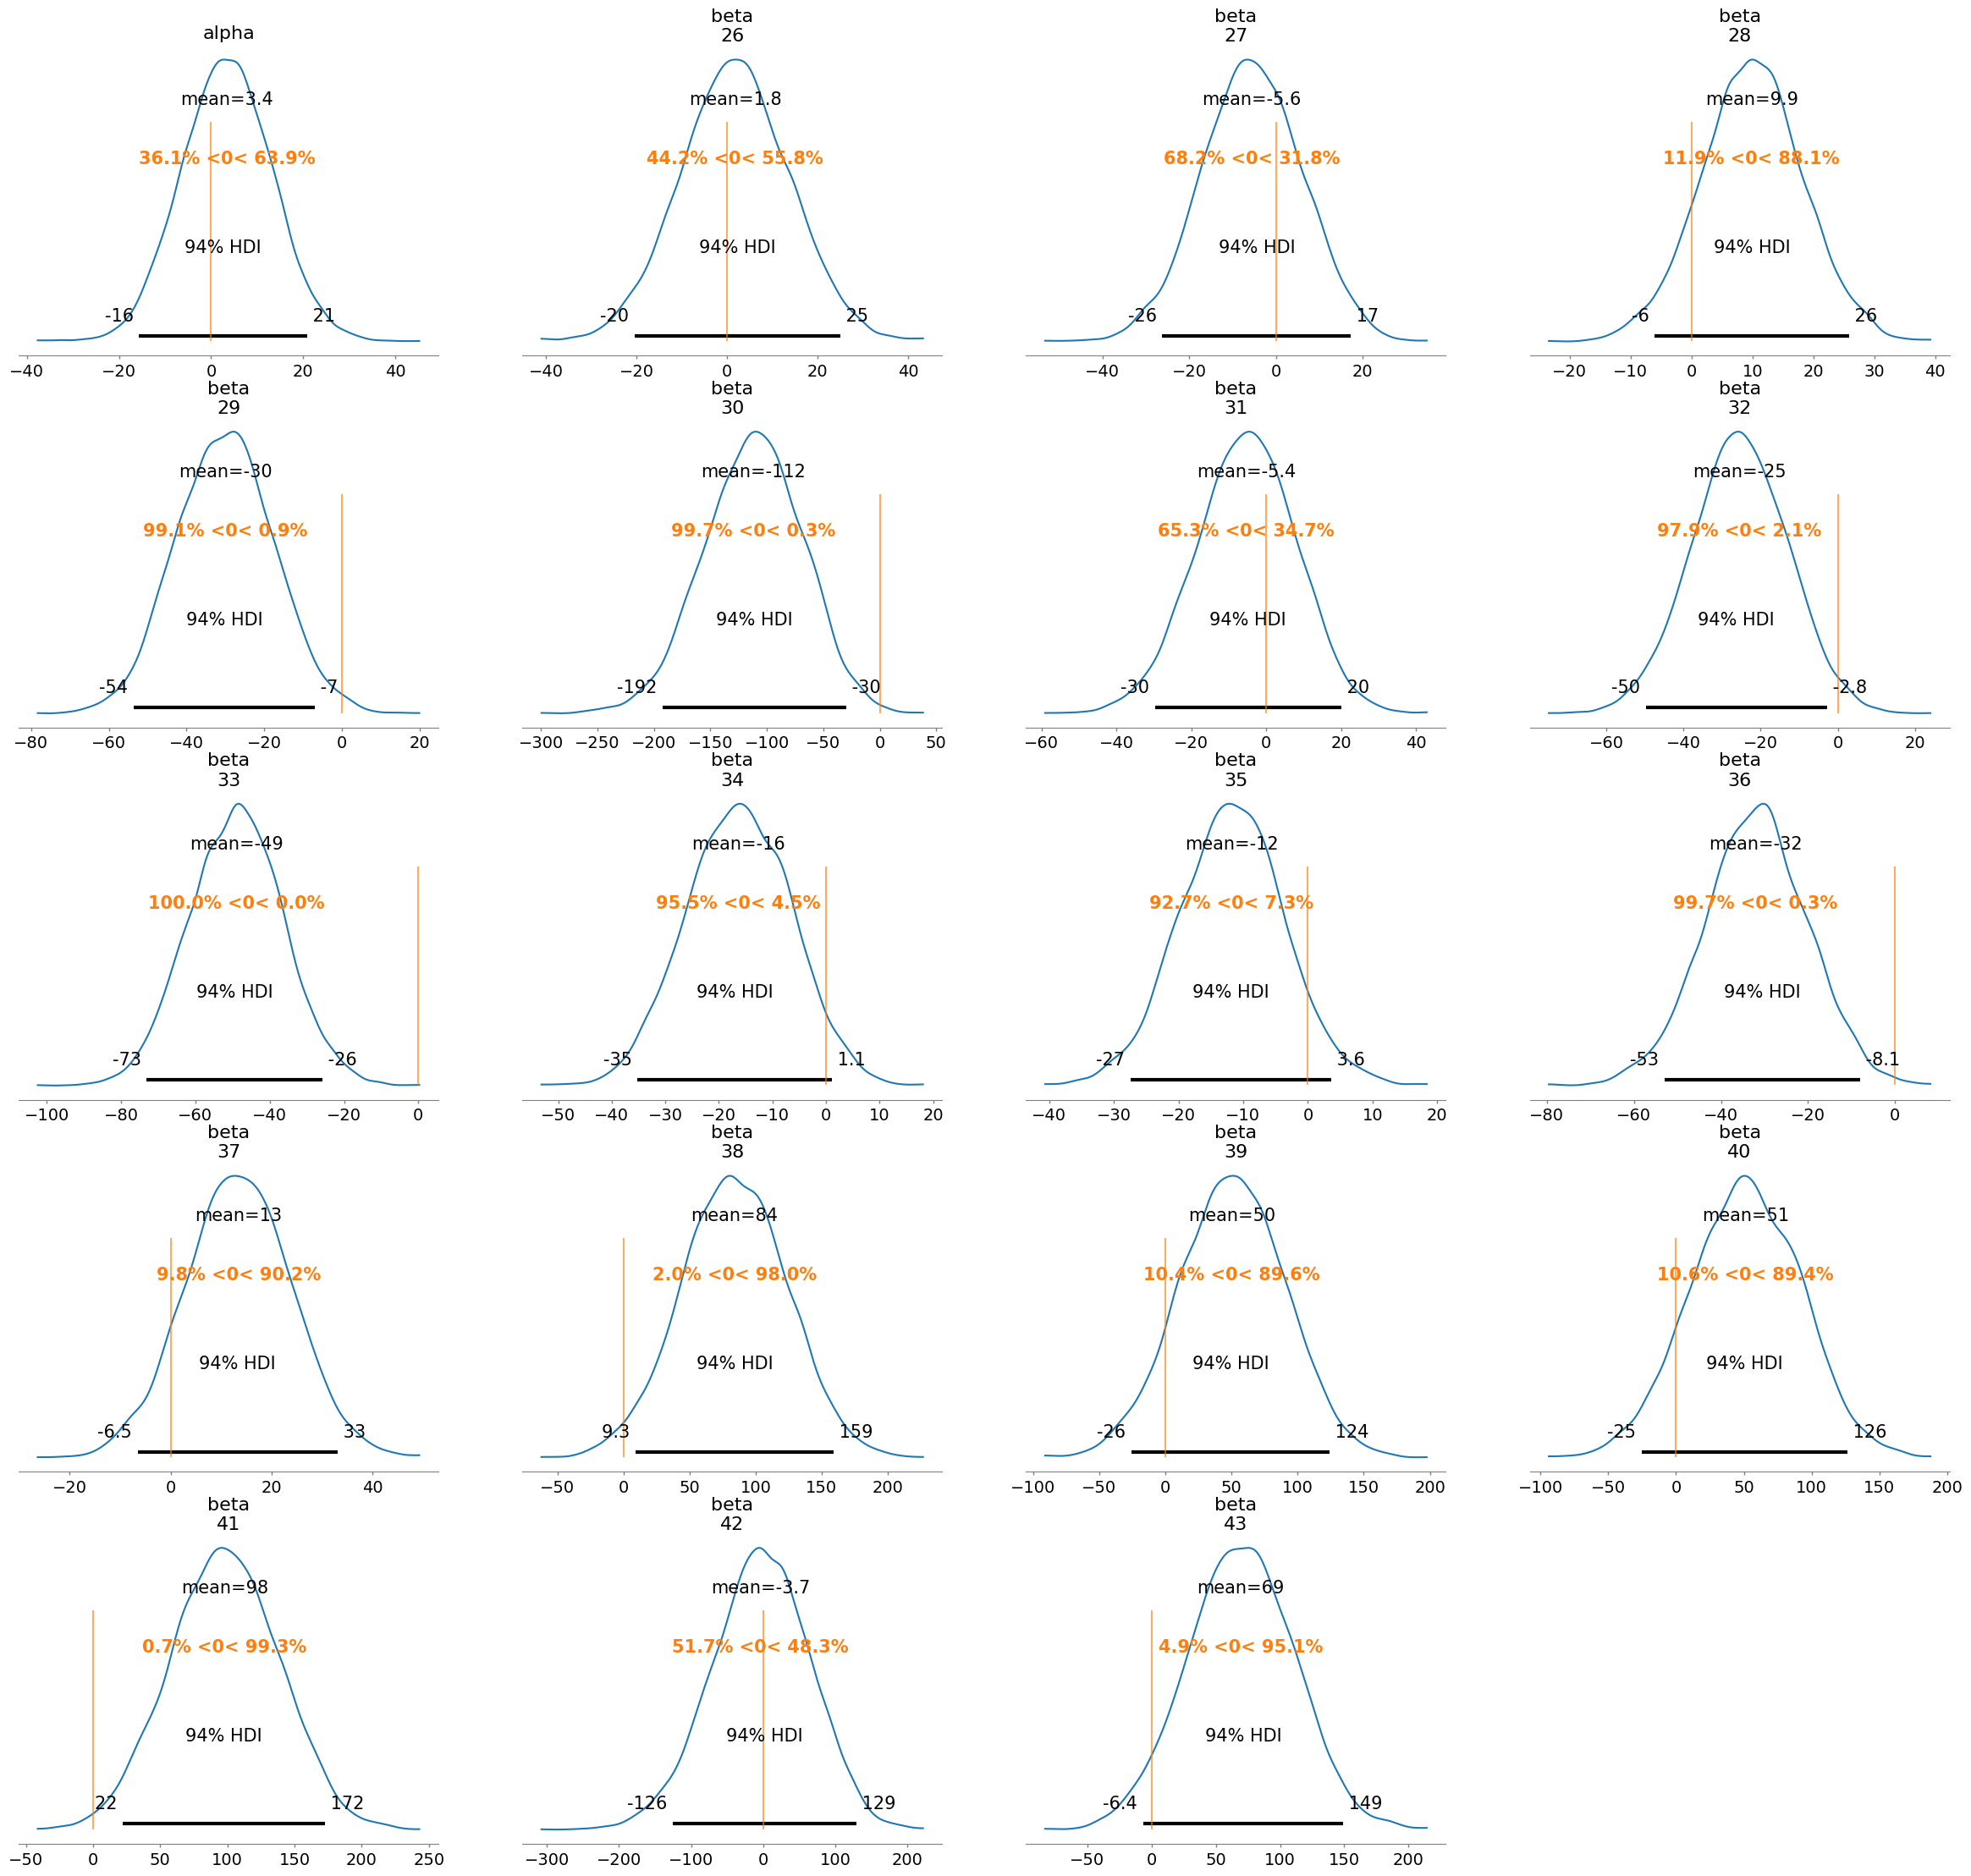

In [90]:
az.plot_posterior(
    run_inference,
    var_names = ['alpha', 'beta'],
    ref_val=0,
    coords={'beta_dim_0': slice(26, 45)}
);

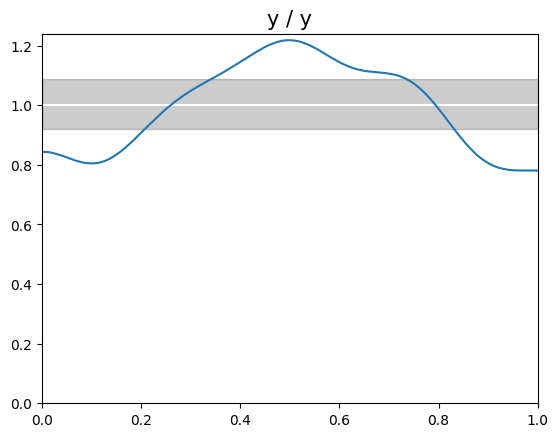

In [93]:
az.plot_bpv(run_pp);

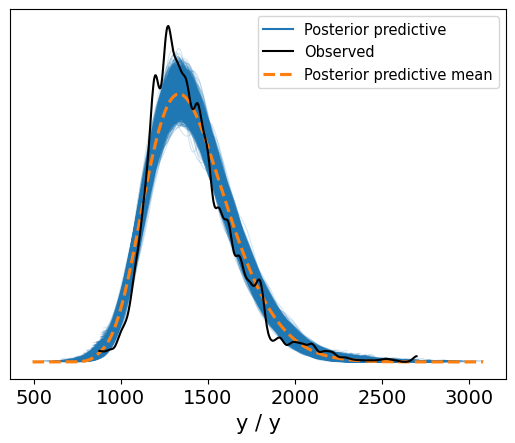

In [94]:
az.plot_ppc(run_pp);

In [95]:
pm.waic(run_inference)

c:\Users\brown\miniconda3\envs\DSenv\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 posterior samples and 2000 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -13311.49    41.30
p_waic       54.99        -

There has been a warning during the calculation. Please check the results.